In [1]:
import numpy as np
import sympy as sp
sp.init_printing(use_latex=True)
from sympy.physics.quantum import Bra, Ket, qapply, Dagger as Dag
from sympy.physics.quantum.cg import CG
np.set_printoptions(precision=3,suppress=True,linewidth=100000, edgeitems=10000)
from sympy.physics.wigner import wigner_9j
from sympy.physics.secondquant import KroneckerDelta
import math
import time
import scipy.linalg
import IPython.display

In [2]:
import matplotlib.pyplot as plt
import MarksConstants as mc
import Miscellaneous as misc
import matplotlib.style
matplotlib.style.use('default')

In [3]:
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm

In [4]:
from IPython.display import Latex

In [5]:
g = 0
u = 1

## some helper classes

In [6]:
# from stack exchange...
class OrthogonalKet(Ket):
    @classmethod
    def dual_class(self):
        return OrthogonalBra
    def _eval_innerproduct(self, bra, **hints):
        if len(self.args) != len(bra.args):
            raise ValueError('Cannot multiply a ket that has a different number of labels.')
        for i in range(len(self.args)):
            diff = self.args[i] - bra.args[i]
            diff.simplify()
            if diff.is_nonzero:
                return 0
            if not diff.is_zero:
                return None
        return 1

class OrthogonalBra(Bra):
    @classmethod
    def dual_class(self):
        return OrthogonalKet
OKet = OrthogonalKet
OBra = OrthogonalBra

In [7]:
class multiplyableDict(dict):
    # This class exists so that I can take a basis ref and use it in np.kron()
    # to programatically get the basis ref for multi-particle systems.
    def __mul__(self, other):
        assert(type(other) == type(self))
        newDict = multiplyableDict()
        for key, value in self.items():
            newDict.update({key+"_1": value})
        for key, value in other.items():
            newDict.update({key+"_2": value})
        return newDict

## some functions

In [11]:
def basisSize(J):
    return int(2*J+1)

In [12]:
def createBasisRefs(Lvals, Svals):
    jBasisRef = []
    Jvals = []
    for Lv in Lvals:
        for Sv in Svals:
            Jvals = set(np.arange(abs(Sv - Lv), Sv + Lv+1, 1))
            for Jv in Jvals:
                for mJ in np.arange(-Jv,Jv+1,1):
                    jBasisRef.append(multiplyableDict({"J":Jv, "mJ":mJ, "L":Lv, "S":Sv}))
    lsBasisRef = []
    for Lv in Lvals:
        for mL in np.arange(-Lv,Lv+1,1):
            for Sv in Svals:
                for mS in np.arange(-Sv, Sv+1,1):
                    lsBasisRef.append(multiplyableDict({"L":Lv, "mL":mL, "S":Sv, "mS":mS}))
    return lsBasisRef, jBasisRef, np.kron(lsBasisRef,lsBasisRef), np.kron(jBasisRef,jBasisRef)

In [13]:
def toSympy(state, basis, quiet=False):
    assert(len(state) == len(basis))
    if not quiet:
        print('Basis is: ')
        display(OKet(*basis[0].keys()))
    spState = sp.S(0)
    for stateE, basisE in zip(state, basis):
        if stateE[0] != 0:
            values = sp.S((np.array(list(basisE.values())) * 2).astype(int))
            spState += stateE[0] * OKet(*values / 2)
    return spState

In [14]:
def getColumnState(basis, quantumNums):
    assert(len(basis[0])==len(quantumNums))
    colState = [[0] for _ in range(len(basis))]
    for num, state in enumerate(basis):
        match = True
        for qnum, val in quantumNums.items():
            if val != state[qnum]:
                match = False
        if match:
            colState[num][0] = 1
            return colState
    raise ValueError("No Match! nums were" + str(quantumNums))

In [15]:
def lsToJ(lsBasis, jBasis):
    # expects single atom bases
    assert(len(lsBasis)==len(jBasis))
    op = np.zeros((len(lsBasis),len(jBasis)))
    for lsnum, lsState in enumerate(lsBasis):
        for jnum, jState in enumerate(jBasis):
            L, mL, S, mS = [lsState[key] for key in ['L','mL','S','mS']]
            J, mJ, JL, JS = [jState[key] for key in ['J','mJ', 'L', 'S']]
            # needing to handle this case makes me feel like the actual clebsh gordon coef should be written as
            # <L,mL,S,mS|J,mJ,L2,S2> or so instead of <L,mL,S,mS|J,mJ> as it usually is written. 
            if JL != L or JS != S:
                op[jnum,lsnum] = 0
            else:
                op[jnum,lsnum] += float(CG(L, mL, S, mS, J, mJ).doit())
    return op

In [16]:
def fsOp(basis):
    # expects a two-particle basis, so each element of the basis should 
    # have J_1, mJ_1, L_1, S_1, and J_2, mJ_2, L_2, S_2 values.
    op = np.zeros((len(basis),len(basis)))
    J1,mJ1,L1,S1,J2,mJ2,L2,S2 = [0 for _ in range(8)]
    names = ['J','mJ','L','S']
    for s1num, state1 in enumerate(basis):
        for s2num, state2 in enumerate(basis):
            val = 1
            qNums = [0 for _ in range(8)]
            for num, name in enumerate(names):
                if state2[name+"_1"] != state1[name+"_1"]:
                    # matrix is diagonal.
                    val = 0
                qNums[num] = state1[name+"_1"]
            for num, name in enumerate(names):
                if state2[name+"_2"] != state1[name+"_2"]:
                    # matrix is diagonal.
                    val = 0
                qNums[num+4] = state1[name+"_2"]
            J1,mJ1,L1,S1,J2,mJ2,L2,S2 = qNums
            # the matrix element is A/2 (L1 . S1 + L2 . S2), A=1
            val *= 0.5*(J1*(J1+1)-L1*(L1+1)-S1*(S1+1)+ J2*(J2+1)-L2*(L2+1)-S2*(S2+1) )
            op[s1num,s2num] = val            
    return op

In [17]:
def createMovrePichlerMatrix(states, fsOperator, offset=-1/2):
    num = len(states)
    op = np.array([[0.0 for _ in states] for _ in states])
    for num, _ in enumerate(states):
        op[num,num] = offset
    for num1, state1 in enumerate(states):
        for num2, state2 in enumerate(states):
            op[num1,num2] += state2.T@fsOperator@state1
    return op    

In [18]:
def createBOMatrix(C3, R, *states):
    # expects states to be a list of lists where the low level list has the values of L, Lambda, S,Sigma, and sigma.
    matrix = np.array([[0.0 for _ in states] for _ in states])
    # the matrix is diagonal.
    for num, state in enumerate(states):
        L, Lambda, S, Sigma, sigma = state
        #print(L, Lambda, S, Sigma, sigma)
        p = (-1)**(S+sigma)
        matrix[num,num] = -p*(3*Lambda**2-L*(L+1))/R**3 * C3
        #print(-p*(3*Lambda**2-L*(L+1))/R**3 * C3)
    return matrix

In [19]:
def BohrOppenheimerToAtomic( oalNums, spinNums, sigma, 
                             lsBasis, jBasis, resInJBasis=True ):
    """
    L is the total molecular orbital angular momentum \vec{L} = \vec{l1}+\vec{l2}
    Lambda is the projection of L on the internuclear axis.
    l1 is the orbital angular momentum of atom 1.
    l2 is the orbital angular momentum of atom 2.
    
    S is the total molecular spin angular momentum \vec{s} = \vec{s1}+\vec{s2}
    Sigma is the projection of S on the internuclear axis.
    s1 is the spin angular momentum of atom 1.
    s2 is the spin angular momentum of atom 2.
    
    sigma is the spatial symmetry of the electronic wavefunctions, 
        either 0 for g ("gerude" or symmetric wavefunctions) 
        or 1 for u ("ungerude" or antisymmetric wavefunctions)
    """
    (L, Lambda, la, lb) = oalNums
    (S, Sigma, sa, sb) = spinNums
    state = 0
    p = (-1)**(S+sigma)
    for mla in np.arange(-la,la+1,1):
        for mlb in np.arange(-lb,lb+1,1):
            for msa in np.arange(-sa,sa+1,1):
                for msb in np.arange(-sb,sb+1,1):
                    # CG notation is <j1,mj1,j2,mj2|j3,mj3>
                    oalCoef = float(CG(la,mla,lb,mlb,L,Lambda).doit())
                    spinCoef = float(CG(sa,msa,sb,msb,S,Sigma).doit())
                    if oalCoef == 0 or spinCoef == 0:
                        continue
                    aState1 = getColumnState(lsBasis, {'L':la,'mL':mla,'S':sa,'mS':msa})
                    bState1 = getColumnState(lsBasis, {'L':lb,'mL':mlb,'S':sb,'mS':msb})
                    aState2 = getColumnState(lsBasis, {'L':lb,'mL':mlb,'S':sa,'mS':msa})
                    bState2 = getColumnState(lsBasis, {'L':la,'mL':mla,'S':sb,'mS':msb})
                    # print(oalCoef,spinCoef, np.linalg.norm(aState1), np.linalg.norm(bState1), np.linalg.norm(aState2), np.linalg.norm(bState2))
                    if resInJBasis:
                        lsToJop = lsToJ(lsBasis,jBasis)
                        aState1 = lsToJop@aState1
                        bState1 = lsToJop@bState1
                        aState2 = lsToJop@aState2
                        bState2 = lsToJop@bState2
                    state += oalCoef*spinCoef * (np.kron(aState1,bState1) + p * np.kron(aState2,bState2))
    if (np.linalg.norm(state) == 0):
        raise ValueError('Resulting State had zero norm!')
    state /= np.linalg.norm(state)
    return state

# Calculations

## S+P Alkali Calculations

In [17]:
lsBasis, jBasis, lsBasis2, jBasis2 = createBasisRefs([0,1], [1/2])
lsToJOp = lsToJ(lsBasis,jBasis)
fsOperator = fsOp(jBasis2)

In [18]:
# 0mg
sig_3mg_0mg = BohrOppenheimerToAtomic( (1, 0, 1, 0), (1, 0, 1/2, 1/2), g, lsBasis, jBasis );
pi_3g_0mg   = 2**(-1/2)*( BohrOppenheimerToAtomic( (1, -1, 1, 0), (1, 1, 1/2, 1/2), g, lsBasis, jBasis )
                         +BohrOppenheimerToAtomic( (1, 1, 1, 0), (1, -1, 1/2, 1/2), g, lsBasis, jBasis ))
# order matters 
bo_0mg = [(1,0,1,0,g),(1,-1,1,1,g)]
# 0pg
pi_3g_0pg = 2**(-1/2)*( BohrOppenheimerToAtomic( (1, -1, 1, 0), (1, 1, 1/2, 1/2), g, lsBasis, jBasis )
                        -BohrOppenheimerToAtomic( (1, 1, 1, 0), (1, -1, 1/2, 1/2), g, lsBasis, jBasis ))
sig_1pg_0pg = BohrOppenheimerToAtomic( (1, 0, 1, 0), (0, 0, 1/2, 1/2), g, lsBasis, jBasis );
bo_0pg = [(1,0,0,0,g),(1,-1,1,1,g)]
#1g
sig_3pg_1g = BohrOppenheimerToAtomic( (1, 0, 1, 0), (1, 1, 1/2, 1/2), g, lsBasis, jBasis );
pi_3g_1g = BohrOppenheimerToAtomic( (1, 1, 1, 0), (1, 0, 1/2, 1/2), g, lsBasis, jBasis );
pi_1g_1g = BohrOppenheimerToAtomic( (1, 1, 1, 0), (0, 0, 1/2, 1/2), g, lsBasis, jBasis );
bo_1g = [(1,0,1,1,g), (1,1,1,0,g), (1,1,0,0,g)]
#2g
pi_3g_2g = BohrOppenheimerToAtomic( (1, 1, 1, 0), (1, 1, 1/2, 1/2), g, lsBasis, jBasis );
bo_2g = [(1,1,1,1,g)]
# 0mu
sig_1mu_0mu = BohrOppenheimerToAtomic( (1, 0, 1, 0), (0, 0, 1/2, 1/2), u, lsBasis, jBasis );
pi_3u_0mu = 2**(-1/2)*( BohrOppenheimerToAtomic( (1, -1, 1, 0), (1, 1, 1/2, 1/2), u, lsBasis, jBasis )
                        -BohrOppenheimerToAtomic( (1, 1, 1, 0), (1, -1, 1/2, 1/2), u, lsBasis, jBasis ))
bo_0mu = [(1,0,0,0,u),(1,-1,1,1,u)]
# 0pu
sig_3pu_0pu = BohrOppenheimerToAtomic( (1, 0, 1, 0), (1, 0, 1/2, 1/2), u, lsBasis, jBasis );
pi_3u_0pu = 2**(-1/2)*( BohrOppenheimerToAtomic( (1, -1, 1, 0), (1, 1, 1/2, 1/2), u, lsBasis, jBasis )
                        +BohrOppenheimerToAtomic( (1, 1, 1, 0), (1, -1, 1/2, 1/2), u, lsBasis, jBasis ))
bo_0pu = [(1,0,1,0,u), (1,-1,1,1,u)]
#1u
sig_3mg_1u = BohrOppenheimerToAtomic( (1, 0, 1, 0), (1, 1, 1/2, 1/2), u, lsBasis, jBasis );
pi_3g_1u = BohrOppenheimerToAtomic( (1, 1, 1, 0), (1, 0, 1/2, 1/2), u, lsBasis, jBasis );
pi_1g_1u = BohrOppenheimerToAtomic( (1, 1, 1, 0), (0, 0, 1/2, 1/2), u, lsBasis, jBasis );
bo_1u = [(1,0,1,1,u), (1,1,1,0,u), (1,1,0,0,u)]
#2u
pi_3g_2u = BohrOppenheimerToAtomic( (1, 1, 1, 0), (1, 1, 1/2, 1/2), u, lsBasis, jBasis );
bo_2u = [(1,1,1,1,u)]

In [59]:
V_0mg = createMovrePichlerMatrix((sig_3mg_0mg, pi_3g_0mg), fsOperator)
V_0pg = createMovrePichlerMatrix((sig_1pg_0pg, pi_3g_0pg), fsOperator)
V_1g = createMovrePichlerMatrix((sig_3pg_1g, pi_3g_1g, pi_1g_1g), fsOperator)
V_2g = createMovrePichlerMatrix(((pi_3g_2g,)), fsOperator)

V_0mu = createMovrePichlerMatrix((sig_1mu_0mu, pi_3u_0mu), fsOperator)
V_0pu = createMovrePichlerMatrix((sig_3pu_0pu, pi_3u_0pu), fsOperator)
V_1u = createMovrePichlerMatrix((sig_3mg_1u, pi_3g_1u, pi_1g_1u), fsOperator)
V_2u = createMovrePichlerMatrix(((pi_3g_2u,)), fsOperator)

bigMatrix = createMovrePichlerMatrix( ( pi_3g_0mg,sig_3mg_0mg, pi_3g_0pg, sig_1pg_0pg, sig_3pg_1g, pi_3g_1g, pi_1g_1g, pi_3g_2g,
                                        pi_3u_0mu, sig_1mu_0mu, pi_3u_0pu, sig_3pu_0pu, sig_3mg_1u, pi_3g_1u, pi_1g_1u, pi_3g_2u), 
                                        fsOperator )
bigMatrix.shape

### Rubidium 87 Calculation

In [60]:
lifetime = (mc.Rb87_D1_Lifetime+mc.Rb87_D2_Lifetime)/2
transFreq = 2*np.pi*(mc.Rb87_D2LineFrequency+mc.Rb87_D1LineFrequency)/2
DeltaVal = mc.h*(mc.Rb87_D2LineFrequency-mc.Rb87_D1LineFrequency)# / mc.h
C_3_val = 3*mc.hbar*mc.c**3/(4*lifetime*transFreq**3)# * 1e27 / mc.h
C_3_val = mc.Rb87_C3
print(DeltaVal, C_3_val)

4.7197635548748796e-21 5.94492796981645e-48


In [ ]:
fig, axs = plt.subplots(2,2,figsize=(20,10))
Rvals = np.linspace( 20*mc.a0, 2000*mc.a0, 3000 )
potentialList = [V_0mg, V_0pg, V_0mu, V_0pu, V_1g, V_1u, V_2g, V_2u]
BohrOppenheimerStates = [bo_0mg, bo_0pg, bo_0mu, bo_0pu, bo_1g, bo_1u, bo_2g, bo_2u]
names=[r'$0^-_g$',r'$0^+_g$',r'$0^-_u$',r'$0^+_u$',r'$1_g$',r'$1_u$', r'$2_g$', r'$2_u$']
linestyles=[':','-','-.',':','-','-.',':','-','-.',':','-','-.']
colors, _ = misc.getColors(len(potentialList), cmStr='viridis')
data = [[] for _ in range(len(potentialList)+2)]
for matrixnum, (name, potentialMatrix, c_, boStates) in enumerate(zip(names, potentialList, colors, BohrOppenheimerStates)):
    for rv in Rvals:
        rMatrix = createBOMatrix(C_3_val, rv, *boStates).astype(float) + potentialMatrix * 2 * DeltaVal / 3
        data[matrixnum].append(sorted(np.linalg.eigvals(rMatrix)))
for ax in axs.flatten():
    ax.axhline(-0.0729113, alpha=0.2,color='r')
    ax.axhline(-0.2298518, alpha=0.2,color='r')
    ax.axhline(-0.30207388, alpha=0.2,color='r')
    ax.axhline(-DeltaVal* 1e-9 / mc.h+0.306246, alpha=0.2,color='r')
    ax.axhline(-DeltaVal* 1e-9 / mc.h-0.510410, alpha=0.2,color='r')
    for name, mdata, c_, linestyle in zip(names, data, colors, linestyles):
        if len(np.array(mdata).shape) == 2 or len(np.array(mdata).shape) == 3:
            for lineNum, lineData in enumerate(misc.transpose(mdata)):
                ax.plot(Rvals*1e9, np.array(lineData) * 1e-9 / mc.h, 
                        label=name if lineNum == 0 else None, color=c_, linestyle=linestyle)
        else:
            ax.plot(Rvals*1e9, np.array(mdata) * 1e-9 / mc.h, 
                    label=name, color=c_, linestyle=linestyle)
    ax.set_xlabel('Inter-nuclear distance (nm)')
    ax.set_ylabel('Energy (GHz)')
    ax.grid(alpha=0.1)
    ax.axhline(0.1937408, alpha=0.2,color='r', label='F States')

axs[0,0].set_title('Full Range')
axs[0,0].set_xlim(min(Rvals)*1e9,max(Rvals)*1e9/20)
axs[0,0].legend(ncol=5,fontsize=14)
axs[1,0].set_title('Zoom $5P_{3/2}$')
axs[1,0].set_xlim(min(Rvals)*1e9,max(Rvals)*1e9/10)
axs[1,0].set_ylim(-1000, 500)
axs[0,1].set_title('Super-Zoom $5P_{3/2}""$')
axs[0,1].set_xlim(min(Rvals)*1e9,max(Rvals)*1e9)
axs[0,1].set_ylim(-0.35, 0.25)
axs[1,1].set_title('Zoom $5P_{1/2}$')
axs[1,1].set_xlim(min(Rvals)*1e9,max(Rvals)*1e9/10)
axs[1,1].set_ylim(-8000, -6000);
plt.savefig('Movre-Pischler.png', dpi=200)

# rotation

The rotational energy in the hund's e case is given by  
$$
H_{\text{"rot"}} = \frac{\hbar^2}{2\mu R^2}\hat{N}^2 
$$

So I need to compare this to, say, the fine structure or hyperfine splitting to understand how important it is or isn't.  

In [26]:
def BohrOppenheimerToAtomic( oalNums, spinNums, sigma, 
                             lsBasis, jBasis, resInJBasis=True ):
    """
    oalNums = (L, Lambda, la, lb)
    L is the total molecular orbital angular momentum \vec{L} = \vec{l1}+\vec{l2}
    Lambda is the projection of L on the internuclear axis.
    l1 is the orbital angular momentum of atom 1.
    l2 is the orbital angular momentum of atom 2.
    
    spinNums = (S, Sigma, s1, s2)
    S is the total molecular spin angular momentum \vec{s} = \vec{s1}+\vec{s2}
    Sigma is the projection of S on the internuclear axis.
    s1 is the spin angular momentum of atom 1.
    s2 is the spin angular momentum of atom 2.
    
    sigma is the spatial symmetry of the electronic wavefunctions, 
        either 0 for g ("gerude" or symmetric wavefunctions) 
        or 1 for u ("ungerude" or antisymmetric wavefunctions)
    """
    (L, Lambda, la, lb) = oalNums
    (S, Sigma, sa, sb) = spinNums
    state = 0
    p = (-1)**(S+sigma)
    for mla in np.arange(-la,la+1,1):
        for mlb in np.arange(-lb,lb+1,1):
            for msa in np.arange(-sa,sa+1,1):
                for msb in np.arange(-sb,sb+1,1):
                    # CG notation is <j1,mj1,j2,mj2|j3,mj3>
                    oalCoef = float(CG(la,mla,lb,mlb,L,Lambda).doit())
                    spinCoef = float(CG(sa,msa,sb,msb,S,Sigma).doit())
                    aState1 = getColumnState(lsBasis, {'L':la,'mL':mla,'S':sa,'mS':msa})
                    bState1 = getColumnState(lsBasis, {'L':lb,'mL':mlb,'S':sb,'mS':msb})
                    aState2 = getColumnState(lsBasis, {'L':lb,'mL':mlb,'S':sa,'mS':msa})
                    bState2 = getColumnState(lsBasis, {'L':la,'mL':mla,'S':sb,'mS':msb})
                    if resInJBasis:
                        lsToJop = lsToJ(lsBasis,jBasis)
                        aState1 = lsToJop@aState1
                        bState1 = lsToJop@bState1
                        aState2 = lsToJop@aState2
                        bState2 = lsToJop@bState2
                    state += oalCoef*spinCoef * (np.kron(aState1,bState1) + p * np.kron(aState2,bState2))
    if np.linalg.norm(state) == 0:
        raise ValueError("State has zero norm!")
    state /= np.linalg.norm(state)
    
    return state

$$
|\Lambda S \Sigma I \iota p\rangle
$$

In [27]:
def createMovrePichlerMatrix(states, fsOperator, offset=-1/2):
    num = len(states)
    op = np.array([[0.0 for _ in states] for _ in states])
    for num, _ in enumerate(states):
        op[num,num] = offset
    for num1, state1 in enumerate(states):
        for num2, state2 in enumerate(states):
            op[num1,num2] += state2.T@fsOperator@state1
    return op    

In [28]:
def coef_fs(j_a, j_b, j, ell, L,
         #L, L_a, L_b,
         S, S_a, S_b,
         Lambda, Sigma, Omega, p, J):
    L_a = 0
    L_b = L
    #print(type(ell),type(Omega),type(J))
    sign = (-1)**(ell-Omega-J)
    frac = (1+(-1)**(L_b+ell+p)*(1-KroneckerDelta(Lambda,0)*KroneckerDelta(Sigma,0)))/sp.sqrt(2-KroneckerDelta(Lambda,0)*KroneckerDelta(Sigma,0))
    twoxm1Term = sp.sqrt(int((2*S+1)*(2*j_a+1)*(2*j_b+1)*(2*L+1)))
    cgcoeffs = CG(J,Omega,j,-Omega,ell,0).doit()*CG(L,Lambda,S,Sigma, j,Omega).doit()
    wig = wigner_9j(L_a,S_a,j_a,L_b,S_b,j_b,L,S,j)
    return sign*frac*twoxm1Term*cgcoeffs*wig

In [29]:
def createCaseE_Basis(singleAtomJvals, J):
    caseE_BasisRef = []
    for sigma in ["g","u"]:
        for ja in singleAtomJvals:
            for jb in singleAtomJvals:
                for j in np.arange(abs(ja-jb),ja+jb,1, dtype=float):
                    for ell in np.arange(max([J-2,0]),J+2,1, dtype=float):
                        state = multiplyableDict({"ja":ja, "jb": jb, "j": j, "ell":ell, "sigma":sigma, 'J':J})
                        if state not in caseE_BasisRef:
                            caseE_BasisRef.append(state)
    return caseE_BasisRef

In [30]:
def createRotationalCouplingMatrix(caseE_Basis):
    # creates the matrix in case E, needs to be transformed to case A basis to calculate properly.
    res = np.zeros((len(caseE_Basis),len(caseE_Basis)))
    for indE, stateE in enumerate(caseE_Basis):
        ell = stateE['ell']
        res[indE,indE] = ell*(ell+1)
    return res

In [31]:
def create_EtoA_Matrix(caseA_Basis, caseE_Basis):
    res = np.zeros((len(caseA_Basis), len(caseE_Basis)))
    for extraQN in [1,-1]:
        for aind, stateA in enumerate(caseA_Basis):
            for eind, stateE in enumerate(caseE_Basis):
                p = 0 if (-1)**(J+extraQN)>0 else 1
                res[aind, eind] = coef(stateE['ja'], stateE['jb'], stateE['j'], stateE['ell'], stateA["L"], stateA["S"], 1/2, 1/2, stateA["Lambda"], abs(stateA["Omega"]-stateA["Lambda"]), abs(stateA["Omega"]), p, stateE["J"])
    return res

In [32]:
def createBornOppenheimerBasis(Lvals, Svals):
    # Normal Notaion is |L Lambda sigma S Sigma>, but I need to keep track of more than that for the splittings caused by other interactions.
    # Therefore this creates a very big basis which is probably unnecessary, but the size of the matrices isn't actually prohibitive in these 
    # calculations so it's okay to have degeneracies. 
    boBasisRef = []
    for sigma in ["g","u"]:
        for Lv in Lvals:
            for Lambda in np.arange(-Lv,Lv+1,1):
                for Sv in Svals:
                    for Sigma in np.arange(-Sv, Sv+1,1):
                        state = multiplyableDict({"L":Lv, "Lambda": Lambda, "sigma": sigma, "S":Sv, "Omega":Sigma+Lambda})
                        if state not in boBasisRef:
                            boBasisRef.append(state)
    boBasisRef = list(sorted(boBasisRef, key=lambda state: abs(state["Omega"]) + 100 * ord(state["sigma"])))
    boBasisFancy = []
    for state in boBasisRef:
        spinT = 2*state["S"]+1
        omega = state["Omega"]
        parity = state["sigma"]
        LambdaSymbol = "\Sigma" if state["Lambda"]==0 else "\Pi"
        boBasisFancy.append(Latex(r"$^{"+str(spinT)+ "}" + LambdaSymbol + "_{"+ str(abs(omega)) + "," + parity + "}$"))        
    return boBasisRef, boBasisFancy

In [33]:
from IPython.display import Latex

In [44]:
boBasisDict, basisLatex = createBornOppenheimerBasis([1],[0,1])
for state in basisLatex:
    pass
    #display(state)

In [45]:
lsBasis, jBasis, lsBasis2, jBasis2 = createBasisRefs([0,1], [1/2])
lsToJOp = lsToJ(lsBasis,jBasis)
fsOperator = fsOp(jBasis2)

In [46]:
movrePischlerStates = []
basisDict, basisLatex = createBornOppenheimerBasis([1],[0,1])
for state in basisDict:
    sigma = g if state["sigma"] == "g" else u
    mpstate = BohrOppenheimerToAtomic( (state["L"], state["Lambda"], 1, 0), (state["S"], state["Omega"] - state["Lambda"], 1/2, 1/2), sigma, lsBasis, jBasis )
    if np.isnan(mpstate[0]):
        continue
    movrePischlerStates.append(mpstate)

In [47]:
bigMatrix = createMovrePichlerMatrix( movrePischlerStates, fsOperator )

In [48]:
def createBOMatrix2(C3, R, *states):
    # expects states to be a list of lists where the low level list has the values of L, Lambda, S,Sigma, and sigma.
    matrix = np.array([[0.0 for _ in states] for _ in states])
    # the matrix is diagonal.
    for num, state in enumerate(states):
        #L, Lambda, S, Sigma, sigma = state
        #print(L, Lambda, S, Sigma, sigma)
        sigma = g if state["sigma"]=="g" else u
        p = (-1)**(state["S"]+sigma)
        L = state["L"]
        matrix[num,num] = -p*(3*state["Lambda"]**2-L*(L+1))/R**3 * C3
        #print(-p*(3*Lambda**2-L*(L+1))/R**3 * C3)
    return matrix

In [49]:
lifetime = (mc.Rb87_D1_Lifetime+mc.Rb87_D2_Lifetime)/2
transFreq = 2*np.pi*(mc.Rb87_D2LineFrequency+mc.Rb87_D1LineFrequency)/2
DeltaVal = mc.h*(mc.Rb87_D2LineFrequency-mc.Rb87_D1LineFrequency)# / mc.h
C_3_val = 3*mc.hbar*mc.c**3/(4*lifetime*transFreq**3)# * 1e27 / mc.h
C_3_val = mc.Rb87_C3
print(DeltaVal, C_3_val)

4.7197635548748796e-21 5.94492796981645e-48


In [50]:
1.33*20*mc.a0, 1.35*20*mc.a0

In [51]:
#Rvals = np.linspace( 1.33*20*mc.a0, 1.35*20*mc.a0, 2000 )
Rvals = np.linspace( 1*20*mc.a0, 200*20*mc.a0, 20000 )
colors = ['y','r','b','g']
jvals = [3,10,100,1000]
superdata = [[] for _ in jvals]
for jvalnum, (J, color) in enumerate(zip(jvals, colors)):
    data = superdata[jvalnum]
    #potentialList = [bigMatrix]
    #BohrOppenheimerStates = [bo_0mg, bo_0pg, bo_0mu, bo_0pu, bo_1g, bo_1u, bo_2g, bo_2u]
    #names=[r'$0^-_g$',r'$0^+_g$',r'$0^-_u$',r'$0^+_u$',r'$1_g$',r'$1_u$', r'$2_g$', r'$2_u$']
    #linestyles=[':','-','-.',':','-','-.',':','-','-.',':','-','-.']
    #data = []
    #J = 40
    caseE_basis = createCaseE_Basis([1/2,3/2], J)
    RCM = createRotationalCouplingMatrix(caseE_basis)#*mc.Rb87_M*1e-9**2/(mc.hbar**2)
    etoa = create_EtoA_Matrix(boBasisDict, caseE_basis)
    rotationalEnergy = etoa@RCM@etoa.conj().T
    for rv in Rvals:
        rMatrix = createBOMatrix2(C_3_val, rv, *basisDict).astype(float) + bigMatrix * 2 * DeltaVal / 3 + rotationalEnergy*mc.hbar**2/(mc.Rb87_M)*(1/rv**2)
        #rMatrix = bigMatrix * 2 * DeltaVal / 3 + rotationalEnergy.astype(float)*(1/rv**2)
        data.append(sorted(np.real(np.linalg.eigvals(rMatrix))))

In [ ]:
fig, axs = plt.subplots(3,2,figsize=(30,15))
for jvalnum, (J, color) in enumerate(zip(jvals, colors)):
    data = superdata[jvalnum]
    for ax in axs.flatten():
        #ax.axhline(-0.0729113, alpha=0.2,color='r')
        #ax.axhline(-0.2298518, alpha=0.2,color='r')
        #ax.axhline(-0.30207388, alpha=0.2,color='r')
        #ax.axhline(-DeltaVal* 1e-9 / mc.h+0.306246, alpha=0.2,color='r')
        #ax.axhline(-DeltaVal* 1e-9 / mc.h-0.510410, alpha=0.2,color='r')
        for mdata in misc.transpose(data):
            ax.plot(Rvals*1e9, np.array(mdata) * 1e-9 / mc.h, color=color, linestyle='-')
        ax.set_xlabel('Inter-nuclear distance (nm)')
        ax.set_ylabel('Energy (GHz)')
        ax.grid(alpha=0.1)
        ax.axhline(0.1937408, alpha=0.2,color='r', label='F States')

    axs[0,0].set_title('Full Range')
    axs[0,0].set_xlim(min(Rvals)*1e9,max(Rvals)*1e9/20)
    #axs[0,0].legend(ncol=5,fontsize=14)s
    axs[1,0].set_title('Zoom $5P_{3/2}$')
    axs[1,0].set_xlim(min(Rvals)*1e9,max(Rvals)*1e9/10)
    axs[1,0].set_ylim(-1000, 500)
    axs[0,1].set_title('Super-Zoom $5P_{3/2}""$')
    axs[0,1].set_xlim(min(Rvals)*1e9,max(Rvals)*1e9)
    axs[0,1].set_ylim(-0.35, 0.25)
    axs[1,1].set_title('Zoom $5P_{1/2}$')
    axs[1,1].set_xlim(min(Rvals)*1e9,max(Rvals)*1e9/10)
    axs[1,1].set_ylim(-8000, -6000);
    axs[2,0].set_xlim(1.41,1.42)
    axs[2,0].set_ylim(-3170,-3160)
    axs[2,1].set_xlim(min(Rvals)*1e9, max(Rvals)*1e9)
    plt.savefig('Movre-Pischler-Super-Rotating.png', dpi=200)

In [ ]:
fig, axs = plt.subplots(3,2,figsize=(30,15))
for jvalnum, (J, color) in enumerate(zip(jvals, colors)):
    data = superdata[jvalnum]
    for ax in axs.flatten():
        #ax.axhline(-0.0729113, alpha=0.2,color='r')
        #ax.axhline(-0.2298518, alpha=0.2,color='r')
        #ax.axhline(-0.30207388, alpha=0.2,color='r')
        #ax.axhline(-DeltaVal* 1e-9 / mc.h+0.306246, alpha=0.2,color='r')
        #ax.axhline(-DeltaVal* 1e-9 / mc.h-0.510410, alpha=0.2,color='r')
        for mdata in misc.transpose(data):
            ax.plot(Rvals*1e9, np.array(mdata) * 1e-9 / mc.h, color=color, linestyle='-')
        ax.set_xlabel('Inter-nuclear distance (nm)')
        ax.set_ylabel('Energy (GHz)')
        ax.grid(alpha=0.1)
        ax.axhline(0.1937408, alpha=0.2,color='r', label='F States')

    axs[0,0].set_title('Full Range')
    axs[0,0].set_xlim(min(Rvals)*1e9,max(Rvals)*1e9/20)
    #axs[0,0].legend(ncol=5,fontsize=14)
    axs[1,0].set_title('Zoom $5P_{3/2}$')
    axs[1,0].set_xlim(min(Rvals)*1e9,max(Rvals)*1e9/10)
    axs[1,0].set_ylim(-1000, 500)
    axs[0,1].set_title('Super-Zoom $5P_{3/2}""$')
    axs[0,1].set_xlim(min(Rvals)*1e9,max(Rvals)*1e9)
    axs[0,1].set_ylim(-0.35, 0.25)
    axs[1,1].set_title('Zoom $5P_{1/2}$')
    axs[1,1].set_xlim(min(Rvals)*1e9,max(Rvals)*1e9/10)
    axs[1,1].set_ylim(-8000, -6000);
    axs[2,0].set_xlim(1.41,1.42)
    axs[2,0].set_ylim(-3170,-3160)
    axs[2,1].set_xlim(min(Rvals)*1e9, max(Rvals)*1e9)
    plt.savefig('Movre-Pischler-Super-Rotating.png', dpi=200)

In [ ]:
fig, axs = plt.subplots(3,2,figsize=(30,15))
for jvalnum, (J, color) in enumerate(zip(jvals[:-1], colors)):
    data = superdata[jvalnum]
    for ax in axs.flatten():
        #ax.axhline(-0.0729113, alpha=0.2,color='r')
        #ax.axhline(-0.2298518, alpha=0.2,color='r')
        #ax.axhline(-0.30207388, alpha=0.2,color='r')
        #ax.axhline(-DeltaVal* 1e-9 / mc.h+0.306246, alpha=0.2,color='r')
        #ax.axhline(-DeltaVal* 1e-9 / mc.h-0.510410, alpha=0.2,color='r')
        for mdata in misc.transpose(data):
            ax.plot(Rvals*1e9, np.array(mdata) * 1e-9 / mc.h, color=color, linestyle='-', linewidth=1)
        ax.set_xlabel('Inter-nuclear distance (nm)')
        ax.set_ylabel('Energy (GHz)')
        ax.grid(alpha=0.1)
        ax.axhline(0.1937408, alpha=0.2,color='r', label='F States')

    axs[0,0].set_title('Full Range')
    axs[0,0].set_xlim(min(Rvals)*1e9,max(Rvals)*1e9/20)
    #axs[0,0].legend(ncol=5,fontsize=14)
    axs[1,0].set_title('Zoom $5P_{3/2}$')
    axs[1,0].set_xlim(min(Rvals)*1e9,max(Rvals)*1e9/10)
    axs[1,0].set_ylim(-1000, 500)
    axs[0,1].set_title('Super-Zoom $5P_{3/2}""$')
    axs[0,1].set_xlim(min(Rvals)*1e9,max(Rvals)*1e9)
    axs[0,1].set_ylim(-0.35, 0.25)
    axs[1,1].set_title('Zoom $5P_{1/2}$')
    axs[1,1].set_xlim(min(Rvals)*1e9,max(Rvals)*1e9/10)
    axs[1,1].set_ylim(-8000, -6000);
    axs[2,0].set_xlim(1.41,1.42)
    axs[2,0].set_ylim(-3170,-3160)
    axs[2,1].set_xlim(min(Rvals)*1e9, max(Rvals)*1e9)
    plt.savefig('Movre-Pischler-W-Rotation.png', dpi=200)

### S+P Alkali Calculations

In [36]:
lsBasis, jBasis, lsBasis2, jBasis2 = createBasisRefs([0,1], [1/2])
lsToJOp = lsToJ(lsBasis,jBasis)
fsOperator = fsOp(jBasis2)

In [43]:
boBasis = ( pi_3g_0mg,sig_3mg_0mg, pi_3g_0pg, sig_1pg_0pg, sig_3pg_1g, pi_3g_1g, pi_1g_1g, pi_3g_2g,
            pi_3u_0mu, sig_1mu_0mu, pi_3u_0pu, sig_3pu_0pu, sig_3mg_1u, pi_3g_1u, pi_1g_1u, pi_3g_2u)

In [37]:
# 0mg
sig_3mg_0mg = BohrOppenheimerToAtomic( (1, 0, 1, 0), (1, 0, 1/2, 1/2), g, lsBasis, jBasis );
pi_3g_0mg   = 2**(-1/2)*( BohrOppenheimerToAtomic( (1, -1, 1, 0), (1, 1, 1/2, 1/2), g, lsBasis, jBasis )
                         +BohrOppenheimerToAtomic( (1, 1, 1, 0), (1, -1, 1/2, 1/2), g, lsBasis, jBasis ))
# order matters 
bo_0mg = [(1,0,1,0,g),(1,-1,1,1,g)]
# 0pg
pi_3g_0pg = 2**(-1/2)*( BohrOppenheimerToAtomic( (1, -1, 1, 0), (1, 1, 1/2, 1/2), g, lsBasis, jBasis )
                        -BohrOppenheimerToAtomic( (1, 1, 1, 0), (1, -1, 1/2, 1/2), g, lsBasis, jBasis ))
sig_1pg_0pg = BohrOppenheimerToAtomic( (1, 0, 1, 0), (0, 0, 1/2, 1/2), g, lsBasis, jBasis );
bo_0pg = [(1,0,0,0,g),(1,-1,1,1,g)]
#1g
sig_3pg_1g = BohrOppenheimerToAtomic( (1, 0, 1, 0), (1, 1, 1/2, 1/2), g, lsBasis, jBasis );
pi_3g_1g = BohrOppenheimerToAtomic( (1, 1, 1, 0), (1, 0, 1/2, 1/2), g, lsBasis, jBasis );
pi_1g_1g = BohrOppenheimerToAtomic( (1, 1, 1, 0), (0, 0, 1/2, 1/2), g, lsBasis, jBasis );
bo_1g = [(1,0,1,1,g), (1,1,1,0,g), (1,1,0,0,g)]
#2g
pi_3g_2g = BohrOppenheimerToAtomic( (1, 1, 1, 0), (1, 1, 1/2, 1/2), g, lsBasis, jBasis );
bo_2g = [(1,1,1,1,g)]
# 0mu
sig_1mu_0mu = BohrOppenheimerToAtomic( (1, 0, 1, 0), (0, 0, 1/2, 1/2), u, lsBasis, jBasis );
pi_3u_0mu = 2**(-1/2)*( BohrOppenheimerToAtomic( (1, -1, 1, 0), (1, 1, 1/2, 1/2), u, lsBasis, jBasis )
                        -BohrOppenheimerToAtomic( (1, 1, 1, 0), (1, -1, 1/2, 1/2), u, lsBasis, jBasis ))
bo_0mu = [(1,0,0,0,u),(1,-1,1,1,u)]
# 0pu
sig_3pu_0pu = BohrOppenheimerToAtomic( (1, 0, 1, 0), (1, 0, 1/2, 1/2), u, lsBasis, jBasis );
pi_3u_0pu = 2**(-1/2)*( BohrOppenheimerToAtomic( (1, -1, 1, 0), (1, 1, 1/2, 1/2), u, lsBasis, jBasis )
                        +BohrOppenheimerToAtomic( (1, 1, 1, 0), (1, -1, 1/2, 1/2), u, lsBasis, jBasis ))
bo_0pu = [(1,0,1,0,u), (1,-1,1,1,u)]
#1u
sig_3mg_1u = BohrOppenheimerToAtomic( (1, 0, 1, 0), (1, 1, 1/2, 1/2), u, lsBasis, jBasis );
pi_3g_1u = BohrOppenheimerToAtomic( (1, 1, 1, 0), (1, 0, 1/2, 1/2), u, lsBasis, jBasis );
pi_1g_1u = BohrOppenheimerToAtomic( (1, 1, 1, 0), (0, 0, 1/2, 1/2), u, lsBasis, jBasis );
bo_1u = [(1,0,1,1,u), (1,1,1,0,u), (1,1,0,0,u)]
#2u
pi_3g_2u = BohrOppenheimerToAtomic( (1, 1, 1, 0), (1, 1, 1/2, 1/2), u, lsBasis, jBasis );
bo_2u = [(1,1,1,1,u)]

In [38]:
V_0mg = createMovrePichlerMatrix((sig_3mg_0mg, pi_3g_0mg), fsOperator)
V_0pg = createMovrePichlerMatrix((sig_1pg_0pg, pi_3g_0pg), fsOperator)
V_1g = createMovrePichlerMatrix((sig_3pg_1g, pi_3g_1g, pi_1g_1g), fsOperator)
V_2g = createMovrePichlerMatrix(((pi_3g_2g,)), fsOperator)

V_0mu = createMovrePichlerMatrix((sig_1mu_0mu, pi_3u_0mu), fsOperator)
V_0pu = createMovrePichlerMatrix((sig_3pu_0pu, pi_3u_0pu), fsOperator)
V_1u = createMovrePichlerMatrix((sig_3mg_1u, pi_3g_1u, pi_1g_1u), fsOperator)
V_2u = createMovrePichlerMatrix(((pi_3g_2u,)), fsOperator)

bigMatrix = createMovrePichlerMatrix( ( pi_3g_0mg,sig_3mg_0mg, pi_3g_0pg, sig_1pg_0pg, sig_3pg_1g, pi_3g_1g, pi_1g_1g, pi_3g_2g,
                                        pi_3u_0mu, sig_1mu_0mu, pi_3u_0pu, sig_3pu_0pu, sig_3mg_1u, pi_3g_1u, pi_1g_1u, pi_3g_2u), 
                                        fsOperator )
bigMatrix.shape

In [39]:
lifetime = (mc.Rb87_D1_Lifetime+mc.Rb87_D2_Lifetime)/2
transFreq = 2*np.pi*(mc.Rb87_D2LineFrequency+mc.Rb87_D1LineFrequency)/2
DeltaVal = mc.h*(mc.Rb87_D2LineFrequency-mc.Rb87_D1LineFrequency)# / mc.h
C_3_val = 3*mc.hbar*mc.c**3/(4*lifetime*transFreq**3)# * 1e27 / mc.h
C_3_val = mc.Rb87_C3
print(DeltaVal, C_3_val)

4.7197635548748796e-21 5.94492796981645e-48


In [ ]:
fig, axs = plt.subplots(2,2,figsize=(20,10))
Rvals = np.linspace( 20*mc.a0, 2000*mc.a0, 3000 )
potentialList = [V_0mg, V_0pg, V_0mu, V_0pu, V_1g, V_1u, V_2g, V_2u]
BohrOppenheimerStates = [bo_0mg, bo_0pg, bo_0mu, bo_0pu, bo_1g, bo_1u, bo_2g, bo_2u]
names=[r'$0^-_g$',r'$0^+_g$',r'$0^-_u$',r'$0^+_u$',r'$1_g$',r'$1_u$', r'$2_g$', r'$2_u$']
linestyles=[':','-','-.',':','-','-.',':','-','-.',':','-','-.']
colors, _ = misc.getColors(len(potentialList), cmStr='viridis')
data = [[] for _ in range(len(potentialList)+2)]
for matrixnum, (name, potentialMatrix, c_, boStates) in enumerate(zip(names, potentialList, colors, BohrOppenheimerStates)):
    for rv in Rvals:
        rMatrix = createBOMatrix(C_3_val, rv, *boStates).astype(float) + potentialMatrix * 2 * DeltaVal / 3
        data[matrixnum].append(sorted(np.linalg.eigvals(rMatrix)))
for ax in axs.flatten():
    ax.axhline(-0.0729113, alpha=0.2,color='r')
    ax.axhline(-0.2298518, alpha=0.2,color='r')
    ax.axhline(-0.30207388, alpha=0.2,color='r')
    ax.axhline(-DeltaVal* 1e-9 / mc.h+0.306246, alpha=0.2,color='r')
    ax.axhline(-DeltaVal* 1e-9 / mc.h-0.510410, alpha=0.2,color='r')
    for name, mdata, c_, linestyle in zip(names, data, colors, linestyles):
        if len(np.array(mdata).shape) == 2 or len(np.array(mdata).shape) == 3:
            for lineNum, lineData in enumerate(misc.transpose(mdata)):
                ax.plot(Rvals*1e9, np.array(lineData) * 1e-9 / mc.h, 
                        label=name if lineNum == 0 else None, color=c_, linestyle=linestyle)
        else:
            ax.plot(Rvals*1e9, np.array(mdata) * 1e-9 / mc.h, 
                    label=name, color=c_, linestyle=linestyle)
    ax.set_xlabel('Inter-nuclear distance (nm)')
    ax.set_ylabel('Energy (GHz)')
    ax.grid(alpha=0.1)
    ax.axhline(0.1937408, alpha=0.2,color='r', label='F States')

axs[0,0].set_title('Full Range')
axs[0,0].set_xlim(min(Rvals)*1e9,max(Rvals)*1e9/20)
axs[0,0].legend(ncol=5,fontsize=14)
axs[1,0].set_title('Zoom $5P_{3/2}$')
axs[1,0].set_xlim(min(Rvals)*1e9,max(Rvals)*1e9/10)
axs[1,0].set_ylim(-1000, 500)
axs[0,1].set_title('Super-Zoom $5P_{3/2}""$')
axs[0,1].set_xlim(min(Rvals)*1e9,max(Rvals)*1e9)
axs[0,1].set_ylim(-0.35, 0.25)
axs[1,1].set_title('Zoom $5P_{1/2}$')
axs[1,1].set_xlim(min(Rvals)*1e9,max(Rvals)*1e9/10)
axs[1,1].set_ylim(-8000, -6000);
plt.savefig('Movre-Pischler.png', dpi=200)

In [98]:
print(mc.hbar/(mc.Rb87_M*(1.4e-9)**2)*1e-6, "MHz")

372.82527330070377 MHz


# Symmetrized Hyperfine

In [193]:
def createBornOppenheimerBasisHFS_Sym(Lvals, Svals, Ivals, sigmavals=["g","u"]):
    # Good quantum numbers: |c Lambda S Sigma I iota p>
    # why does L enter in here?
    boBasisRef = []
    for sigma in sigmavals:
        for Lv in Lvals:
            for Lambda in np.arange(-Lv,Lv+1,1):
                for Sv in Svals:
                    for Sigma in np.arange(-Sv, Sv+1,1):
                        for i1 in Ivals:
                            for i2 in Ivals:
                                for I in np.arange(abs(i2-i1), i2+i1+1,1):
                                    for iota in np.arange(-I,I+1,1):
                                        #state = multiplyableDict({"L":Lv, "Lambda": Lambda, "S":Sv, "Sigma":Sigma, "i":I, "iota":iota, "i1":i1, "i2":i2,
                                        #                          "Omega":Sigma+Lambda, "phi": Sigma+Lambda+iota })
                                        Omega = Sigma+Lambda
                                        if Lambda != 0 and Omega==0:
                                            for sigmav in [-1,1]:
                                                state = multiplyableDict({"L":Lv, "|Lambda|": abs(Lambda), "sigma": sigma, "S":Sv, "|Sigma|":abs(Sigma), "i":I, "iota":iota, "i1":i1, "i2":i2,
                                                                          "Omega":Omega, "|phi|": abs(Sigma+Lambda+iota), "sigma_vxz": 2*sigmav })
                                                if state not in boBasisRef:
                                                    boBasisRef.append(state)
                                        else:
                                            state = multiplyableDict({"L":Lv, "|Lambda|": abs(Lambda), "sigma": sigma, "S":Sv, "|Sigma|":abs(Sigma), "i":I, "iota":iota, "i1":i1, "i2":i2,
                                                                      "Omega":Omega, "|phi|": abs(Sigma+Lambda+iota), "sigma_vxz": (-1)**(Lv-Lambda+Sv-Sigma) })
                                            if state not in boBasisRef:
                                                boBasisRef.append(state)
    # sort by omega and sigma value. should probably change...
    #boBasisRef = list(sorted(boBasisRef, key=lambda state: abs(state["Omega"]) + 100 * ord(state["sigma"])))
    boBasisRef = list(sorted(boBasisRef, key=lambda state: abs(state["Omega"])))
    return boBasisRef

In [213]:
boBasisDict_fullSym = createBornOppenheimerBasisHFS_Sym([1],[0,1], [3/2], sigmavals=['g', 'u'])

In [212]:
boBasisDict_full = createBornOppenheimerBasisHFS([1],[0,1], [3/2], sigmavals=['g', 'u'])

In [ ]:
for state in boBasisDict_full[:]:
    print(state)
    print('matches:')
    for state2 in boBasisDict_fullSym:
        if ( state2['L']==state['L'] and abs(state['Lambda']) == abs(state2['|Lambda|']) 
             and state['sigma']==state2['sigma'] and state['S'] == state2['S'] and state['Omega']==state2['Omega']):
            print(state2)
    print('\n')

In [214]:
print(len(boBasisDict_full), len(boBasisDict_fullSym))

384 384


In [215]:
A_gs = (mc.Rb87_Ground_ToF2-mc.Rb87_Ground_ToF1)/2
A_12 = (mc.Rb87_5P12_ToF2-mc.Rb87_5P12_ToF1)/2
A_32 = (mc.Rb87_5P32_ToF3-mc.Rb87_5P32_ToF0)/6

In [216]:
lifetime = (mc.Rb87_D1_Lifetime+mc.Rb87_D2_Lifetime)/2
transFreq = 2*np.pi*(mc.Rb87_D2LineFrequency+mc.Rb87_D1LineFrequency)/2
DeltaVal = mc.h*(mc.Rb87_D2LineFrequency-mc.Rb87_D1LineFrequency)# / mc.h
C_3_val = 3*mc.hbar*mc.c**3/(4*lifetime*transFreq**3)# * 1e27 / mc.h
C_3_val = mc.Rb87_C3
print(DeltaVal, C_3_val)

4.7197635548748796e-21 5.94492796981645e-48


In [217]:
print(boBasisDict_full[0])

{'L': 1, 'Lambda': -1, 'sigma': 'g', 'S': 1, 'Sigma': 1, 'i': 0.0, 'iota': -0.0, 'i1': 1.5, 'i2': 1.5, 'Omega': 0, 'phi': 0.0}


In [218]:
lsiBasis, jiBasis, fBasis, lsiBasis2Atom, jiBasis2Atom, fBasis2Atom = createLargerBasisRefs([0,1], [1/2], [3/2])
fsOperator = fsOp(jiBasis2Atom)
hfsOperator = hfsOp(fBasis2Atom, A_12, A_gs, mc.Rb87_5P32_ToF3,mc.Rb87_5P32_ToF2,mc.Rb87_5P32_ToF1,mc.Rb87_5P32_ToF0)
lsiToJiop = lsiToJi(lsiBasis,jiBasis)
jiToFOp = jiTof(jiBasis, fBasis)
boBasisDict_g = createBornOppenheimerBasisHFS([1],[0,1], [3/2], sigmavals=['g'])
boBasisDict_u = createBornOppenheimerBasisHFS([1],[0,1], [3/2], sigmavals=['u'])
boBasisDict_full = createBornOppenheimerBasisHFS([1],[0,1], [0], sigmavals=['g', 'u'])

In [221]:
boBasisDict_fullSym[0]

{'L': 1,
 '|Lambda|': 1,
 'sigma': 'g',
 'S': 1,
 '|Sigma|': 1,
 'i': 0.0,
 'iota': -0.0,
 'i1': 1.5,
 'i2': 1.5,
 'Omega': 0,
 '|phi|': 0.0,
 'sigma_vxz': -2}

In [223]:
# Full basis including 
numPhi=6
phiBases = [[] for _ in range(numPhi)]
for phi in range(numPhi):
    for state in boBasisDict_fullSym:
        sigmav = g if state['sigma'] == 'g' else u
        if math.isclose(abs(state['|phi|']),phi):# and (-1)**(state['i']+state['S']+sigmav)==1:
            #print(state['S'])
            phiBases[phi].append(state)

$$
(-1)^{\sigma+p+S+I}
$$

In [227]:
H_fs_phi = [[] for _ in phiBases]
H_hfs_phi = [[] for _ in phiBases]
for phiV, phiBase in enumerate(phiBases):
    IPython.display.clear_output(wait=True)
    print('Working on Phi ' + str(phiV) +". " + str(len(phiBase)) + " states")
    fsStates = []
    hfsStates = []
    boBasisDict = phiBase
    print('Converting BO states to FS and HFS bases')
    for num, state in enumerate(boBasisDict):
        misc.reportProgress(num, len(boBasisDict))
        sigma = g if state["sigma"] == "g" else u
        I, iota, i1, i2 = [state[k] for k in ["i","iota","i1","i2"]]
        mpstate, indvCont, lsiBasisStates, jiBasisStates = BohrOppenheimerToAtomic( (state["L"], state["|Lambda|"], 1, 0), 
                                                                                   (state["S"], state["Omega"] - state["|Lambda|"], 1/2, 1/2), 
                                                                                   (I, iota, i1, i2), sigma, lsiBasis, basisChange=lsiToJiop )
        hfsState, indvCont, lsiBasisStates, fBasisStates = BohrOppenheimerToAtomic( (state["L"], state["|Lambda|"], 1, 0), 
                                                                                   (state["S"], state["Omega"] - state["|Lambda|"], 1/2, 1/2), 
                                                                                   (I, iota, i1, i2), sigma, lsiBasis, basisChange=jiToFOp@lsiToJiop )
        if np.isnan(mpstate[0]):
            continue
        fsStates.append(mpstate);
        hfsStates.append(hfsState)
    print('Complete\nCalcualting FS Energies')
    H_fs_phi[phiV] = createCouplingMatrix( fsStates, fsOperator, offset=-1/2)#, boBasis=boBasisDict )
    print('Complete\nCalcualting HFS Energies')
    H_hfs_phi[phiV] = createCouplingMatrix( hfsStates, hfsOperator, offset=0)#, boBasis=boBasisDict )
    print('Complete')
    time.sleep(1)

Working on Phi 0. 76 states
Converting BO states to FS and HFS bases


ValueError: State has zero norm!

# Hyperfine structure

First without rotation, should be similar to adding fine structure.

In [35]:
def lsiToJi(lsiBasis, jiBasis):
    # expects single atom bases
    assert(len(lsiBasis)==len(jiBasis))
    op = np.zeros((len(lsiBasis),len(jiBasis)))
    for lsnum, lsiState in enumerate(lsiBasis):
        for jnum, jiState in enumerate(jiBasis):
            # there should be some repeats because of the i values in each basis
            L, mL, S, mS, I_lsi, mI_lsi = [lsiState[key] for key in ['L','mL','S','mS', 'I', 'mI']]
            J, mJ, JL, JS, I_ji, mI_ji = [jiState[key] for key in ['J','mJ', 'L', 'S', 'I', 'mI']]
            # needing to handle this case makes me feel like the actual clebsh gordon coef should be written as
            # <L,mL,S,mS|J,mJ,L2,S2> or so instead of <L,mL,S,mS|J,mJ> as it usually is written. 
            if JL != L or JS != S or I_lsi != I_ji or mI_lsi != mI_ji:
                op[jnum,lsnum] = 0
            else:
                op[jnum,lsnum] += float(CG(L, mL, S, mS, J, mJ).doit())
    return op

In [36]:
def createBOMatrix2(C3, R, *states):
    # expects states to be a list of lists where the low level list has the values of L, Lambda, S,Sigma, and sigma.
    matrix = np.array([[0.0 for _ in states] for _ in states])
    # the matrix is diagonal.
    for num, state in enumerate(states):
        #L, Lambda, S, Sigma, sigma = state
        sigma = g if state["sigma"]=="g" else u
        p = (-1)**(state["S"]+sigma)
        L = state["L"]
        matrix[num,num] = -p*(3*state["Lambda"]**2-L*(L+1))/R**3 * C3
    return matrix

In [37]:
def createLargerBasisRefs(Lvals, Svals, Ivals):
    fBasisRef = []
    for Lv in Lvals:
        for Sv in Svals:
            Jvals = set(np.arange(abs(Sv - Lv), Sv + Lv+1, 1))
            for Jv in Jvals:
                for Iv in Ivals:
                    FVals = set(np.arange(abs(Jv - Iv), Jv + Iv+1, 1))
                    for Fv in FVals:
                        for mf in np.arange(-Fv,Fv+1,1):
                            fBasisRef.append(multiplyableDict({"F":Fv, "mF": mf, "J":Jv, "L":Lv, "S":Sv, "I":Iv}))
    jiBasisRef = []
    for Lv in Lvals:
        for Sv in Svals:
            Jvals = set(np.arange(abs(Sv - Lv), Sv + Lv+1, 1))
            for Jv in Jvals:
                for mJ in np.arange(-Jv,Jv+1,1):
                    for Iv in Ivals:
                        for mi in np.arange(-Iv,Iv+1,1):
                            jiBasisRef.append(multiplyableDict({"J":Jv, "mJ":mJ, "L":Lv, "S":Sv, "I":Iv, "mI":mi}))
    lsiBasisRef = []
    for Lv in Lvals:
        for mL in np.arange(-Lv,Lv+1,1):
            for Sv in Svals:
                for mS in np.arange(-Sv, Sv+1,1):
                    for Iv in Ivals:
                        for mi in np.arange(-Iv,Iv+1,1):
                            lsiBasisRef.append(multiplyableDict({"L":Lv, "mL":mL, "S":Sv, "mS":mS, "I":Iv, "mI":mi}))
    return lsiBasisRef, jiBasisRef, fBasisRef, np.kron(lsiBasisRef,lsiBasisRef), np.kron(jiBasisRef,jiBasisRef), np.kron(fBasisRef,fBasisRef)

In [38]:
def createBornOppenheimerBasisFin():
    # Good quantum numbers: |c Lambda S Sigma I iota p>
    # why does L enter in here?
    Lv = 1
    iv = 3/2
    Svals = [0,1]
    boBasisRef = []
    for Sv in Svals:
        for Lambda in np.arange(0,Lv+1,1):
            for Sigma in np.arange(0,Sv+1,1):
                for Iv in np.arange(0,2*iv+1,1):
                    for iota in np.arange(0,Iv+1,1):
                        for parity in [-1,1]:
                            state = multiplyableDict({"Lambda": Lambda, "S":Sv, "Sigma":Sigma, "I":Iv, "iota":iota, 
                                                      "Omega":Sigma+Lambda, "phi": Sigma+Lambda+iota, "parity":parity })
                            if state not in boBasisRef:
                                boBasisRef.append(state)
    # sort by omega and sigma value. should probably change...
    #boBasisRef = list(sorted(boBasisRef, key=lambda state: abs(state["Omega"]) + 100 * ord(state["sigma"])))
    boBasisRef = list(sorted(boBasisRef, key=lambda state: abs(state["Omega"])))
    return boBasisRef

In [42]:
def createBornOppenheimerBasisHFS(Lvals, Svals, Ivals, sigmavals=["g","u"]):
    # Good quantum numbers: |c Lambda S Sigma I iota p>
    # why does L enter in here?
    boBasisRef = []
    for sigma in sigmavals:
        for Lv in Lvals:
            for Lambda in np.arange(-Lv,Lv+1,1):
                for Sv in Svals:
                    for Sigma in np.arange(-Sv, Sv+1,1):
                        for i1 in Ivals:
                            for i2 in Ivals:
                                for I in np.arange(abs(i2-i1), i2+i1+1,1):
                                    for iota in np.arange(-I,I+1,1):
                                        #state = multiplyableDict({"L":Lv, "Lambda": Lambda, "S":Sv, "Sigma":Sigma, "i":I, "iota":iota, "i1":i1, "i2":i2,
                                        #                          "Omega":Sigma+Lambda, "phi": Sigma+Lambda+iota })
                                        state = multiplyableDict({"L":Lv, "Lambda": Lambda, "sigma": sigma, "S":Sv, "Sigma":Sigma, "i":I, "iota":iota, "i1":i1, "i2":i2,
                                                                  "Omega":Sigma+Lambda, "phi": Sigma+Lambda+iota })
                                        if state not in boBasisRef:
                                            boBasisRef.append(state)
    # sort by omega and sigma value. should probably change...
    #boBasisRef = list(sorted(boBasisRef, key=lambda state: abs(state["Omega"]) + 100 * ord(state["sigma"])))
    boBasisRef = list(sorted(boBasisRef, key=lambda state: abs(state["Omega"])))
    return boBasisRef

In [43]:
def BohrOppenheimerToAtomic( oalNums, spinNums, nuclearNums, sigma, 
                             lsBasis, basisChange=None ):
    """
    oalNums = (L, Lambda, la, lb)
    L is the total molecular orbital angular momentum \vec{L} = \vec{l1}+\vec{l2}
    Lambda is the projection of L on the internuclear axis.
    l1 is the orbital angular momentum of atom 1.
    l2 is the orbital angular momentum of atom 2.
    
    spinNums = (S, Sigma, sa, sb)
    S is the total molecular spin angular momentum \vec{s} = \vec{s1}+\vec{s2}
    Sigma is the projection of S on the internuclear axis.
    s1 is the spin angular momentum of atom 1.
    s2 is the spin angular momentum of atom 2.
    
    nuclearNums = (I, iota, ia, ib)
    
    sigma is the spatial symmetry of the electronic wavefunctions, 
        either 0 for g ("gerude" or symmetric wavefunctions) 
        or 1 for u ("ungerude" or antisymmetric wavefunctions)
    """
    (L, Lambda, la, lb) = oalNums
    (S, Sigma, sa, sb) = spinNums
    (I, iota, ia, ib) = nuclearNums
    state = 0
    p = (-1)**(S+sigma)
    indvCont = []
    lsiBasisStates = []
    otherBasisStates = []
    for mla in np.arange(-la,la+1,1):
        mlb = Lambda-mla
        if abs(mlb) > lb:
            continue
        #for mlb in np.arange(-lb,lb+1,1):
        for msa in np.arange(-sa,sa+1,1):
            msb = Sigma-msa
            if abs(msb) > sb:
                continue
            #        for msb in np.arange(-sb,sb+1,1):
            for mia in np.arange(-ia, ia+1, 1):
                mib = iota-mia
                if abs(mib) > ib:
                    continue
                # for mib in np.arange(-ib,ib+1,1):
                # CG notation is <j1,mj1,j2,mj2|j3,mj3>
                oalCoef = float(CG(la,mla,lb,mlb,L,Lambda).doit())
                spinCoef = float(CG(sa,msa,sb,msb,S,Sigma).doit())
                nuclearCoef = float(CG(ia,mia,ib,mib,I,iota).doit())
                aState1 = getColumnState(lsiBasis, {'L':la,'mL':mla,'S':sa,'mS':msa, 'I':ia,'mI':mia})
                bState1 = getColumnState(lsiBasis, {'L':lb,'mL':mlb,'S':sb,'mS':msb, 'I':ib,'mI':mib})
                aState2 = getColumnState(lsiBasis, {'L':lb,'mL':mlb,'S':sa,'mS':msa, 'I':ia,'mI':mia})
                bState2 = getColumnState(lsiBasis, {'L':la,'mL':mla,'S':sb,'mS':msb, 'I':ib,'mI':mib})
                if oalCoef != 0 and nuclearCoef != 0 and spinCoef != 0:
                    lsiBasisStates.append([aState1, bState1, aState2, bState2])
                if basisChange is not None:
                    aState1 = basisChange@aState1
                    bState1 = basisChange@bState1
                    aState2 = basisChange@aState2
                    bState2 = basisChange@bState2
                newpart = nuclearCoef*oalCoef*spinCoef * (np.kron(aState1,bState1) + p * np.kron(aState2,bState2))
                state += newpart
                if oalCoef != 0 and nuclearCoef != 0 and spinCoef != 0:
                    indvCont.append(newpart)
                    otherBasisStates.append([aState1, bState1, aState2, bState2])

    if np.linalg.norm(state) == 0:
        raise ValueError("State has zero norm!")
    state /= np.linalg.norm(state)
    return state, np.array(indvCont), np.array(lsiBasisStates), np.array(otherBasisStates)

In [44]:
def fsOp(basis):
    # expects a two-particle basis, so each element of the basis should 
    # have J_1, mJ_1, L_1, S_1, and J_2, mJ_2, L_2, S_2 values.
    op = np.zeros((len(basis),len(basis)))
    J1,mJ1,L1,S1,J2,mJ2,L2,S2 = [0 for _ in range(8)]
    names = ['J','mJ','L','S']
    for s1num, state1 in enumerate(basis):
        qNums = [0 for _ in range(8)]
        for num, name in enumerate(names):
            qNums[num] = state1[name+"_1"]
        for num, name in enumerate(names):
            qNums[num+4] = state1[name+"_2"]
        J1,mJ1,L1,S1,J2,mJ2,L2,S2 = qNums
        # the matrix element is A/2 (L1 . S1 + L2 . S2), A=1
        val = 0.5*(J1*(J1+1)-L1*(L1+1)-S1*(S1+1)+ J2*(J2+1)-L2*(L2+1)-S2*(S2+1) )
        op[s1num,s1num] = val
    assert(np.count_nonzero(op - np.diag(np.diagonal(op)))==0)
    return op

In [45]:
def hfsOp(basis, A_12, A_gs, F3E, F2E, F1E, F0E):
    # expects a two-particle basis, so each element of the basis should 
    # have J_1, mJ_1, L_1, S_1, and J_2, mJ_2, L_2, S_2 values.
    op = np.zeros((len(basis),len(basis)))
    f1,mf1,j1,i1,f2,mf2,j2,i2 = [0 for _ in range(8)]
    names = ['F','mF','J','I']
    for s1num, state1 in enumerate(basis):
        qNums = [0 for _ in range(8)]
        for num, name in enumerate(names):
            qNums[num] = state1[name+"_1"]
        for num, name in enumerate(names):
            qNums[num+4] = state1[name+"_2"]
        f1,mf1,j1,i1,f2,mf2,j2,i2 = qNums
        A1 = A_12 if state1["L_1"] == 1 else A_gs
        E1 = A1/2 * (f1*(f1+1)-j1*(j1+1)-i1*(i1+1)) if state1["J_1"] != 3/2 else (F3E if f1==3 else (F2E if f1==2 else (F1E if f1==1 else F0E)))
        A2 = A_12 if state1["L_2"] == 1 else A_gs
        E2 = A2/2 * (f2*(f2+1)-j2*(j2+1)-i2*(i2+1)) if state1["J_2"] != 3/2 else (F3E if f2==3 else (F2E if f2==2 else (F1E if f2==1 else F0E)))
        op[s1num,s1num] = E1 + E2
    return op

In [46]:
def getColumnState(basis, quantumNums):
    assert(len(basis[0])==len(quantumNums))
    colState = [[0] for _ in range(len(basis))]
    for num, state in enumerate(basis):
        match = True
        for qnum, val in quantumNums.items():
            if val != state[qnum]:
                match = False
        if match:
            colState[num][0] = 1
            return colState
    raise ValueError("No Match! nums were" + str(quantumNums))

In [47]:
def createMovrePichlerMatrix(states, fsOperator, offset=-1/2):
    num = len(states)
    op = np.array([[0.0 for _ in states] for _ in states])
    for num, _ in enumerate(states):
        op[num,num] = offset
    for num1, state1 in enumerate(states):
        for num2, state2 in enumerate(states):
            op[num1,num2] += state2.T@fsOperator@state1
    return op    

In [48]:
def jiTof(jiBasis, fBasis):
    # expects single atom bases
    assert(len(jiBasis)==len(fBasis))
    op = np.zeros((len(jiBasis),len(fBasis)))
    for jnum, jiState in enumerate(jiBasis):
        for fnum, fState in enumerate(fBasis):
            J, mJ, L, S, I, mI = [jiState[key] for key in ['J','mJ', 'L', 'S', 'I', 'mI']]
            F, mF, Jf, If, Lf, Sf = [fState[key] for key in ['F','mF','J','I', 'L', 'S']]
            # needing to handle this case makes me feel like the actual clebsh gordon coef should be written as
            # <L,mL,S,mS|J,mJ,L2,S2> or so instead of <L,mL,S,mS|J,mJ> as it usually is written. 
            if Jf != J or If != I or Lf != L or Sf != S:
                op[fnum, jnum] = 0
            else:
                res = float(CG(J, mJ, I, mI, F, mF).doit())
                op[fnum, jnum] += float(CG(J, mJ, I, mI, F, mF).doit())
    return op

In [49]:
def createCouplingMatrix(states, op, offset=-1/2, boBasis=None):
    num = len(states)
    coupleM = np.array([[0.0 for _ in states] for _ in states])
    for num, _ in enumerate(states):
        coupleM[num,num] = offset
    for num1, state1 in enumerate(states):
        misc.reportProgress(num1, len(states))
        for num2, state2 in enumerate(states):
            matElem = state2.T@op@state1
            if boBasis is not None:
                if boBasis[num1]['sigma'] != boBasis[num2]['sigma'] and not math.isclose(matElem, 0, abs_tol=0):
                    continue
                    print(boBasis[num1], '\n', boBasis[num2],'\n', matElem, '\n')
            coupleM[num1,num2] += matElem
    return coupleM    

In [200]:
A_gs = (mc.Rb87_Ground_ToF2-mc.Rb87_Ground_ToF1)/2
A_12 = (mc.Rb87_5P12_ToF2-mc.Rb87_5P12_ToF1)/2
A_32 = (mc.Rb87_5P32_ToF3-mc.Rb87_5P32_ToF0)/6

In [201]:
lifetime = (mc.Rb87_D1_Lifetime+mc.Rb87_D2_Lifetime)/2
transFreq = 2*np.pi*(mc.Rb87_D2LineFrequency+mc.Rb87_D1LineFrequency)/2
DeltaVal = mc.h*(mc.Rb87_D2LineFrequency-mc.Rb87_D1LineFrequency)# / mc.h
C_3_val = 3*mc.hbar*mc.c**3/(4*lifetime*transFreq**3)# * 1e27 / mc.h
C_3_val = mc.Rb87_C3
print(DeltaVal, C_3_val)

4.7197635548748796e-21 5.94492796981645e-48


In [202]:
print(boBasisDict_full[0])

{'L': 1, 'Lambda': -1, 'sigma': 'g', 'S': 1, 'Sigma': 1, 'i': 0, 'iota': 0, 'i1': 0, 'i2': 0, 'Omega': 0, 'phi': 0}


In [205]:
lsiBasis, jiBasis, fBasis, lsiBasis2Atom, jiBasis2Atom, fBasis2Atom = createLargerBasisRefs([0,1], [1/2], [3/2])
fsOperator = fsOp(jiBasis2Atom)
hfsOperator = hfsOp(fBasis2Atom, A_12, A_gs, mc.Rb87_5P32_ToF3,mc.Rb87_5P32_ToF2,mc.Rb87_5P32_ToF1,mc.Rb87_5P32_ToF0)
lsiToJiop = lsiToJi(lsiBasis,jiBasis)
jiToFOp = jiTof(jiBasis, fBasis)
boBasisDict_g = createBornOppenheimerBasisHFS([1],[0,1], [3/2], sigmavals=['g'])
boBasisDict_u = createBornOppenheimerBasisHFS([1],[0,1], [3/2], sigmavals=['u'])
boBasisDict_full = createBornOppenheimerBasisHFS([1],[0,1], [0], sigmavals=['g', 'u'])

In [207]:
# Full basis including 
numPhi=1
phiBases = [[] for _ in range(numPhi)]
for phi in range(numPhi):
    for state in boBasisDict_full:
        sigmav = g if state['sigma'] == 'g' else u
        if math.isclose(abs(state['phi']),phi):# and (-1)**(state['i']+state['S']+sigmav)==1:
            #print(state['S'])
            phiBases[phi].append(state)

$$
(-1)^{\sigma+p+S+I}
$$

In [210]:
H_fs_phi = [[] for _ in phiBases]
H_hfs_phi = [[] for _ in phiBases]
for phiV, phiBase in enumerate(phiBases):
    IPython.display.clear_output(wait=True)
    print('Working on Phi ' + str(phiV) +". " + str(len(phiBase)) + " states")
    fsStates = []
    hfsStates = []
    boBasisDict = phiBase
    print('Converting BO states to FS and HFS bases')
    for num, state in enumerate(boBasisDict):
        misc.reportProgress(num, len(boBasisDict))
        sigma = g if state["sigma"] == "g" else u
        I, iota, i1, i2 = [state[k] for k in ["i","iota","i1","i2"]]
        mpstate, indvCont, lsiBasisStates, jiBasisStates = BohrOppenheimerToAtomic( (state["L"], state["Lambda"], 1, 0), 
                                                                                   (state["S"], state["Omega"] - state["Lambda"], 1/2, 1/2), 
                                                                                   (I, iota, i1, i2), sigma, lsiBasis, basisChange=lsiToJiop )
        hfsState, indvCont, lsiBasisStates, fBasisStates = BohrOppenheimerToAtomic( (state["L"], state["Lambda"], 1, 0), 
                                                                                   (state["S"], state["Omega"] - state["Lambda"], 1/2, 1/2), 
                                                                                   (I, iota, i1, i2), sigma, lsiBasis, basisChange=jiToFOp@lsiToJiop )
        if np.isnan(mpstate[0]):
            continue
        fsStates.append(mpstate);
        hfsStates.append(hfsState)
    print('Complete\nCalcualting FS Energies')
    H_fs_phi[phiV] = createCouplingMatrix( fsStates, fsOperator, offset=-1/2)#, boBasis=boBasisDict )
    print('Complete\nCalcualting HFS Energies')
    H_hfs_phi[phiV] = createCouplingMatrix( hfsStates, hfsOperator, offset=0)#, boBasis=boBasisDict )
    print('Complete')
    time.sleep(1)

Working on Phi 0. 8 states
Converting BO states to FS and HFS bases


ValueError: No Match! nums were{'L': 1, 'mL': -1, 'S': 0.5, 'mS': 0.5, 'I': 0, 'mI': 0}

In [211]:
Rvals = np.linspace( 1*20*mc.a0, 100*20*mc.a0, 1000 )

energies = [np.zeros((len(Rvals),len(phiBase))) for phiBase in phiBases]
guCharacters = [np.zeros((len(Rvals),len(phiBase))) for phiBase in phiBases]
phiCharacter = [np.zeros((len(Rvals),len(phiBase))) for phiBase in phiBases]
pCharacter = [np.zeros((len(Rvals),len(phiBase))) for phiBase in phiBases]

for phi, base in enumerate(phiBases):
    if len(base) == 0:
        continue
    IPython.display.clear_output(wait=True)
    print('\nPhiVal:',phi)
    print('Calcualting Eigenvalues at every R')    
    boBasisDict = base
    for num, rv in enumerate(Rvals):
        misc.reportProgress(num, len(Rvals))
        rmatrix = createBOMatrix2(C_3_val, rv, *boBasisDict).astype(float) + H_fs_phi[phi] * 2 * DeltaVal / 3 + H_hfs_phi[phi] * mc.h
        eigVals, eigVectors = np.linalg.eigh(rmatrix)
        guCharacterIndvR  = np.zeros(len(boBasisDict))
        pCharIndvR = np.zeros(len(boBasisDict))
        for vnum, eigVec in enumerate(misc.transpose(eigVectors)):
            for stateCoef, state in zip(eigVec, boBasisDict):
                pCharIndvR[vnum] += stateCoef**2*(-1)**state['i']
                if state['sigma']=='u':
                    guCharacterIndvR[vnum] += stateCoef**2
                else:
                    assert(state['sigma']=='g')
        tups = zip(eigVals, eigVectors, guCharacterIndvR);
        tups = sorted(tups, key=lambda v: v[0]/mc.h + v[2])
        eigVals, eigVectors, guCharacterIndvR = zip(*tups)
        energies[phi][num] = eigVals
        guCharacters[phi][num] = guCharacterIndvR
        pCharacter[phi][num] = pCharIndvR


PhiVal: 0
Calcualting Eigenvalues at every R


TypeError: can't multiply sequence by non-int of type 'float'

#### zooomed out views

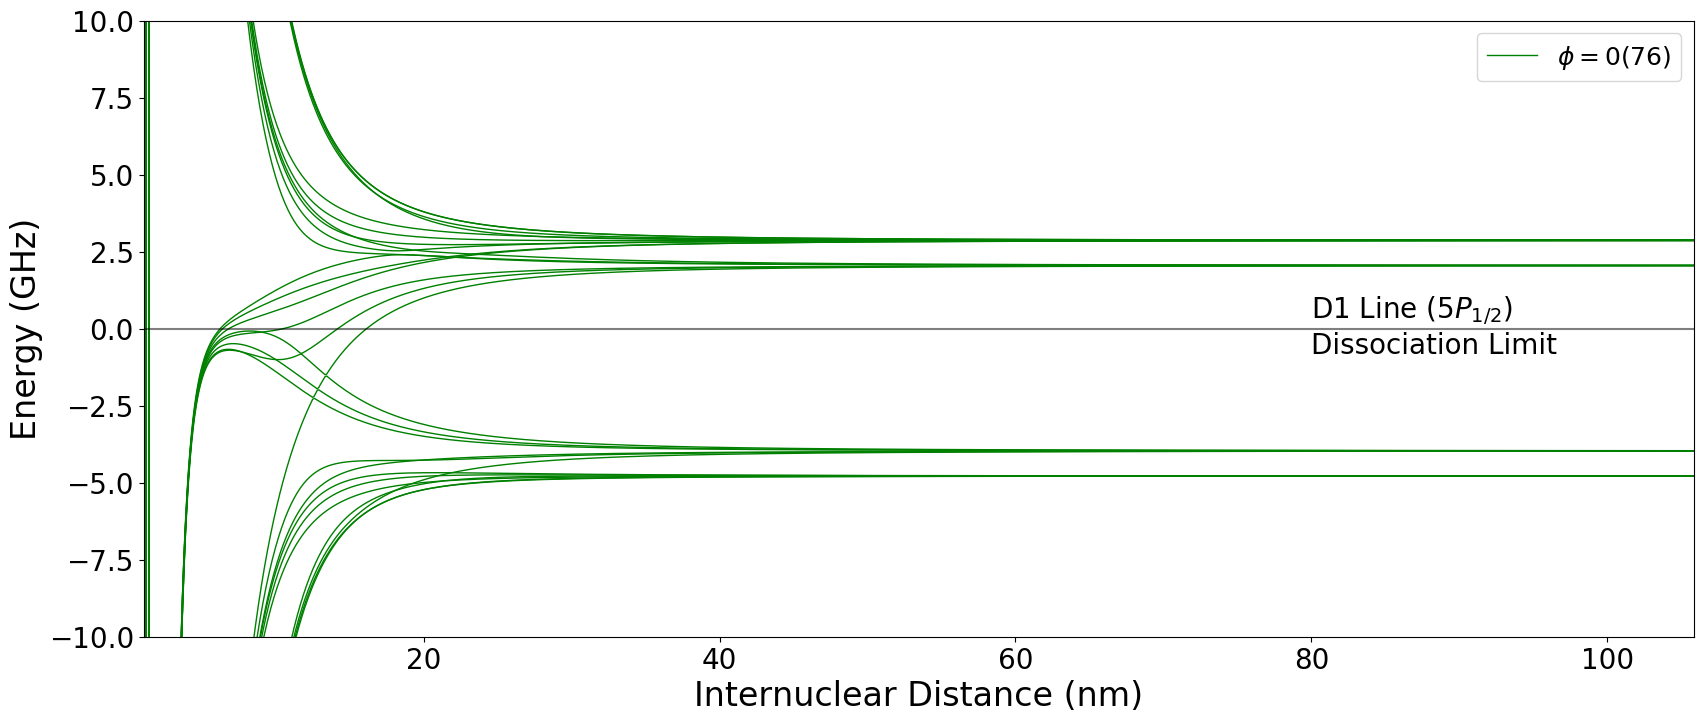

In [95]:
fig, ax = plt.subplots(figsize=(20,8))
gs = fig.add_gridspec(6,2)

yoffset = DeltaVal/mc.h
inc=1
#phiColors, _ = misc.getColors(len(phiBases)+1)#, cmStr='gnuplot')
phiColors=['g','c','b','purple', 'orange','r']
plotByGuCharacter=False
for phiVal, bases in enumerate(phiBases):
    color = phiColors[phiVal]
    for datanum, (mdata, guCharacter) in enumerate(zip(misc.transpose(energies[phiVal])[::inc], misc.transpose(guCharacters[phiVal])[::inc])):
        ax.plot(Rvals*1e9, np.array(mdata) * 1e-9 / mc.h + yoffset/1e9 , 
                color=color, linestyle='-', linewidth=1, 
                label=r'$\phi='+str(phiVal)+'('+str(len(bases))+')$' if datanum==0 else None)
leg = ax.legend(fontsize=18, ncol=3, loc='upper right')
for text in leg.get_texts():
    text.set_color("k")
ax.axhline(0,color='k',alpha=0.5)
ax.text(80,-0.8, "D1 Line $(5P_{1/2})$\nDissociation Limit", fontsize=20, color='k')
ax.set_ylim((-10,10))
ax.set_xlim(min(Rvals)*1e9,max(Rvals)*1e9)
#ax.grid(alpha=0.5)
ax.set_xlabel('Internuclear Distance (nm)',fontsize=24)
#ax.set_xticks(fontsize=20)
ax.set_ylabel('Energy (GHz)',fontsize=24)
ax.tick_params(axis='both', which='major', labelsize=20)
#plt.savefig("Hyperfine_Splitting_Big_Picture.png", dpi=100, transparent=True, bbox_inches='tight', pad_inches=0)

for ref:

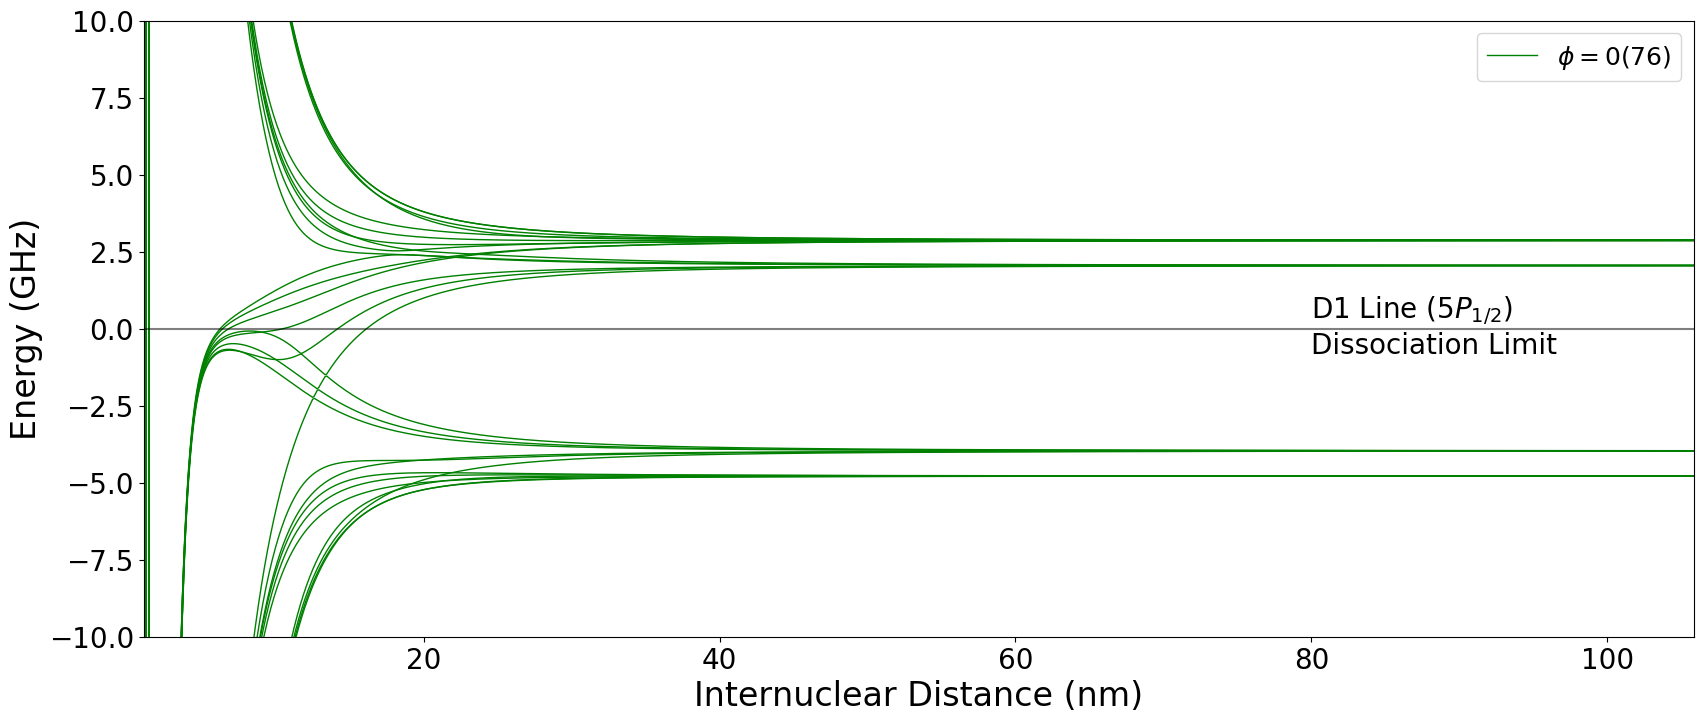

#### just d1

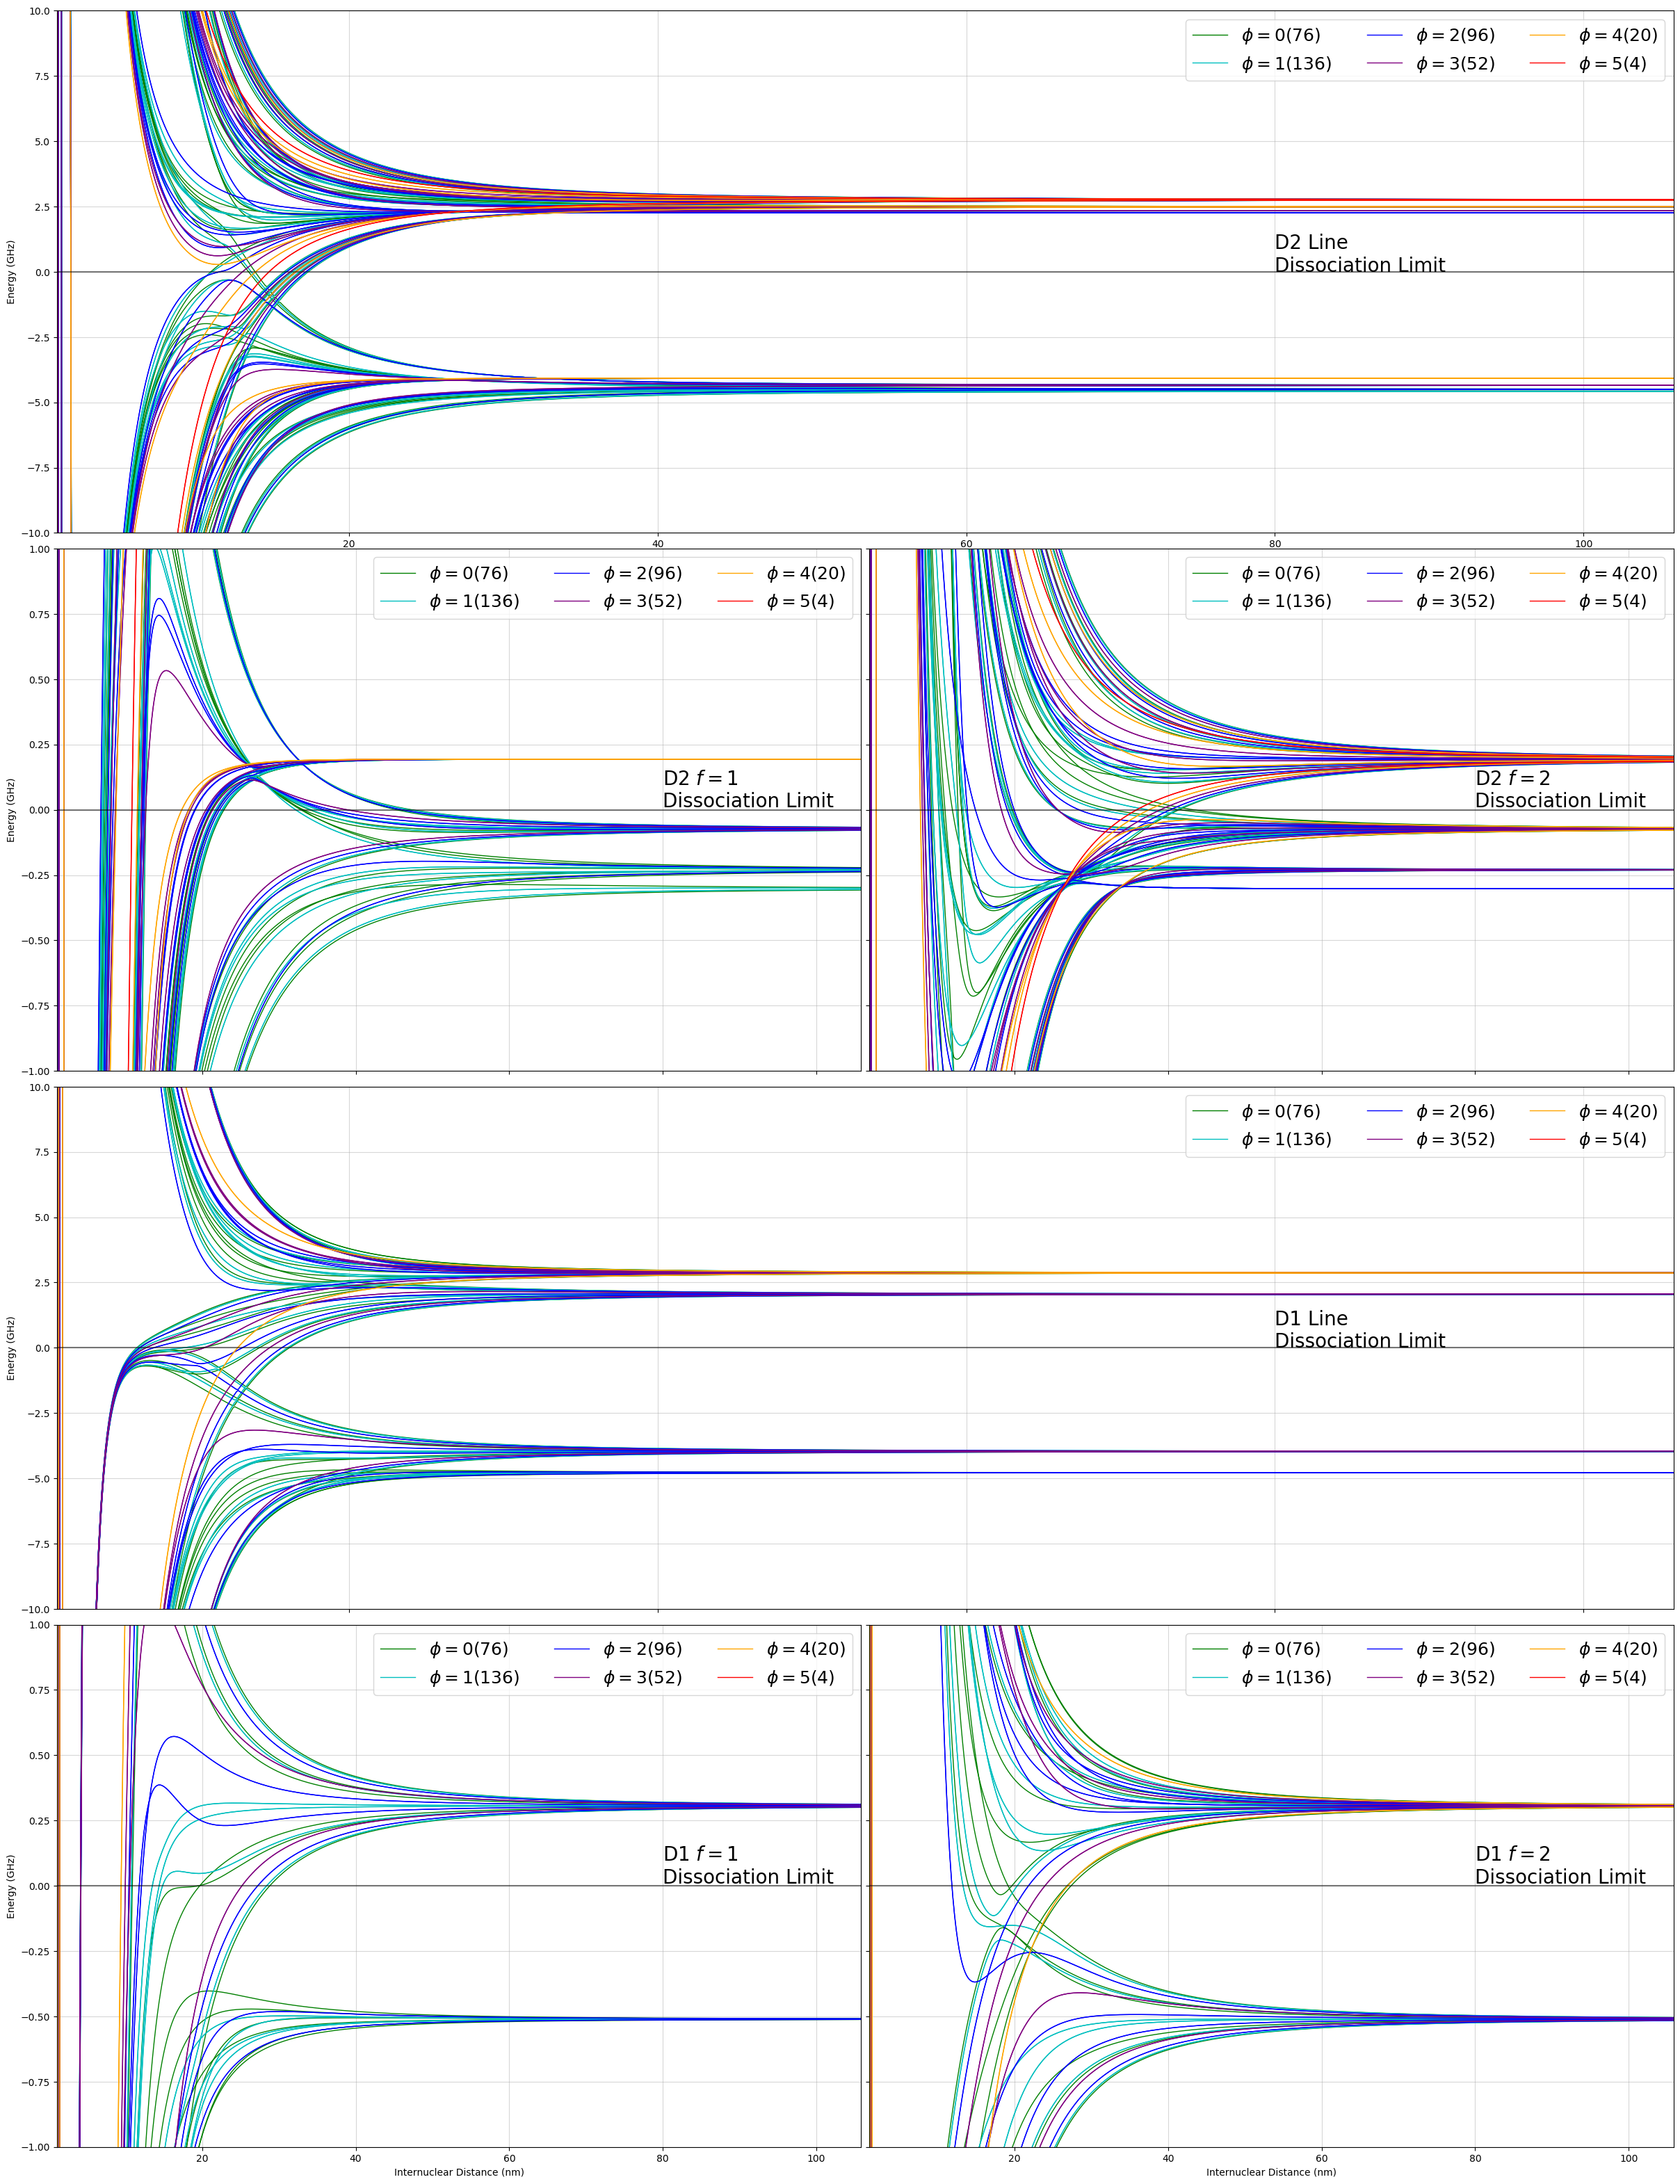

In [60]:
fig = plt.figure(figsize=(30,60))
gs = fig.add_gridspec(6,2)
axs = []
axs.append(fig.add_subplot(gs[0, :]))
axs.append(fig.add_subplot(gs[1, 0]))
axs.append(fig.add_subplot(gs[1, 1]))
axs.append(fig.add_subplot(gs[2, :]))
axs.append(fig.add_subplot(gs[3, 0]))
axs.append(fig.add_subplot(gs[3, 1]))

fig.subplots_adjust(hspace=0.03, wspace=0.01)

titles = ["D2 Line",  
          r"D2 $f=1$",     r"D2 $f=2$",
          "D1 Line",  
          r"D1 $f=1$",     r"D1 $f=2$"]

allYlims = [(-10,10), 
            (-1,1),    (-1,1),
            (-10,10), 
            (-1,1),    (-1,1)]
yoffsets = np.array(
            [0,
            -mc.Rb87_Ground_ToF1,-mc.Rb87_Ground_ToF2,
            DeltaVal/mc.h,
            DeltaVal/mc.h-mc.Rb87_Ground_ToF1,DeltaVal/mc.h-mc.Rb87_Ground_ToF2])/1e9
inc=1
#phiColors, _ = misc.getColors(len(phiBases)+1)#, cmStr='gnuplot')
phiColors=['g','c','b','purple', 'orange','r']
plotByGuCharacter=False
for num, (ax, title, ylims, yoff) in enumerate(zip(axs[:], titles, allYlims, yoffsets)):
    for phiVal, bases in enumerate(phiBases):
        #phiVal=2
        color = phiColors[phiVal]
        for datanum, (mdata, guCharacter) in enumerate(zip(misc.transpose(energies[phiVal])[::inc], misc.transpose(guCharacters[phiVal])[::inc])):
            if plotByGuCharacter:
                points = np.array([Rvals*1e9, np.array(mdata) * 1e-9 / mc.h + yoff]).T.reshape(-1, 1, 2)
                segments = np.concatenate([points[:-1], points[1:]], axis=1)
                lc = LineCollection(segments, cmap='seismic')
                lc.set_array(np.array(guCharacter))
                line = ax.add_collection(lc)
            else:
                ax.plot(Rvals*1e9, np.array(mdata) * 1e-9 / mc.h + yoff , color=color, linestyle='-', linewidth=1, label=r'$\phi='+str(phiVal)+'('+str(len(bases))+')$' if datanum==0 else None)
    leg = ax.legend(fontsize=18, ncol=3, loc='upper right')
    for text in leg.get_texts():
        text.set_color("k")
    ax.axhline(0,color='k',alpha=0.5)
    ax.text(80,0.01, title + "\nDissociation Limit", fontsize=20, color='k')
    ax.set_ylim(*ylims)
    ax.set_xlim(min(Rvals)*1e9,max(Rvals)*1e9)
    ax.grid(alpha=0.5)
    if num != len(axs)-1 and num != len(axs)-2 and num != 0:
        ax.set_xticklabels([]);
    elif num != 0:
        ax.set_xlabel('Internuclear Distance (nm)')
    if num not in [0,1, 3,4]:
        ax.set_yticklabels([])
    else:
        ax.set_ylabel('Energy (GHz)')
plt.savefig("Hyperfine_Splitting_Big_Picture.png", dpi=100, transparent=True, bbox_inches='tight', pad_inches=0)

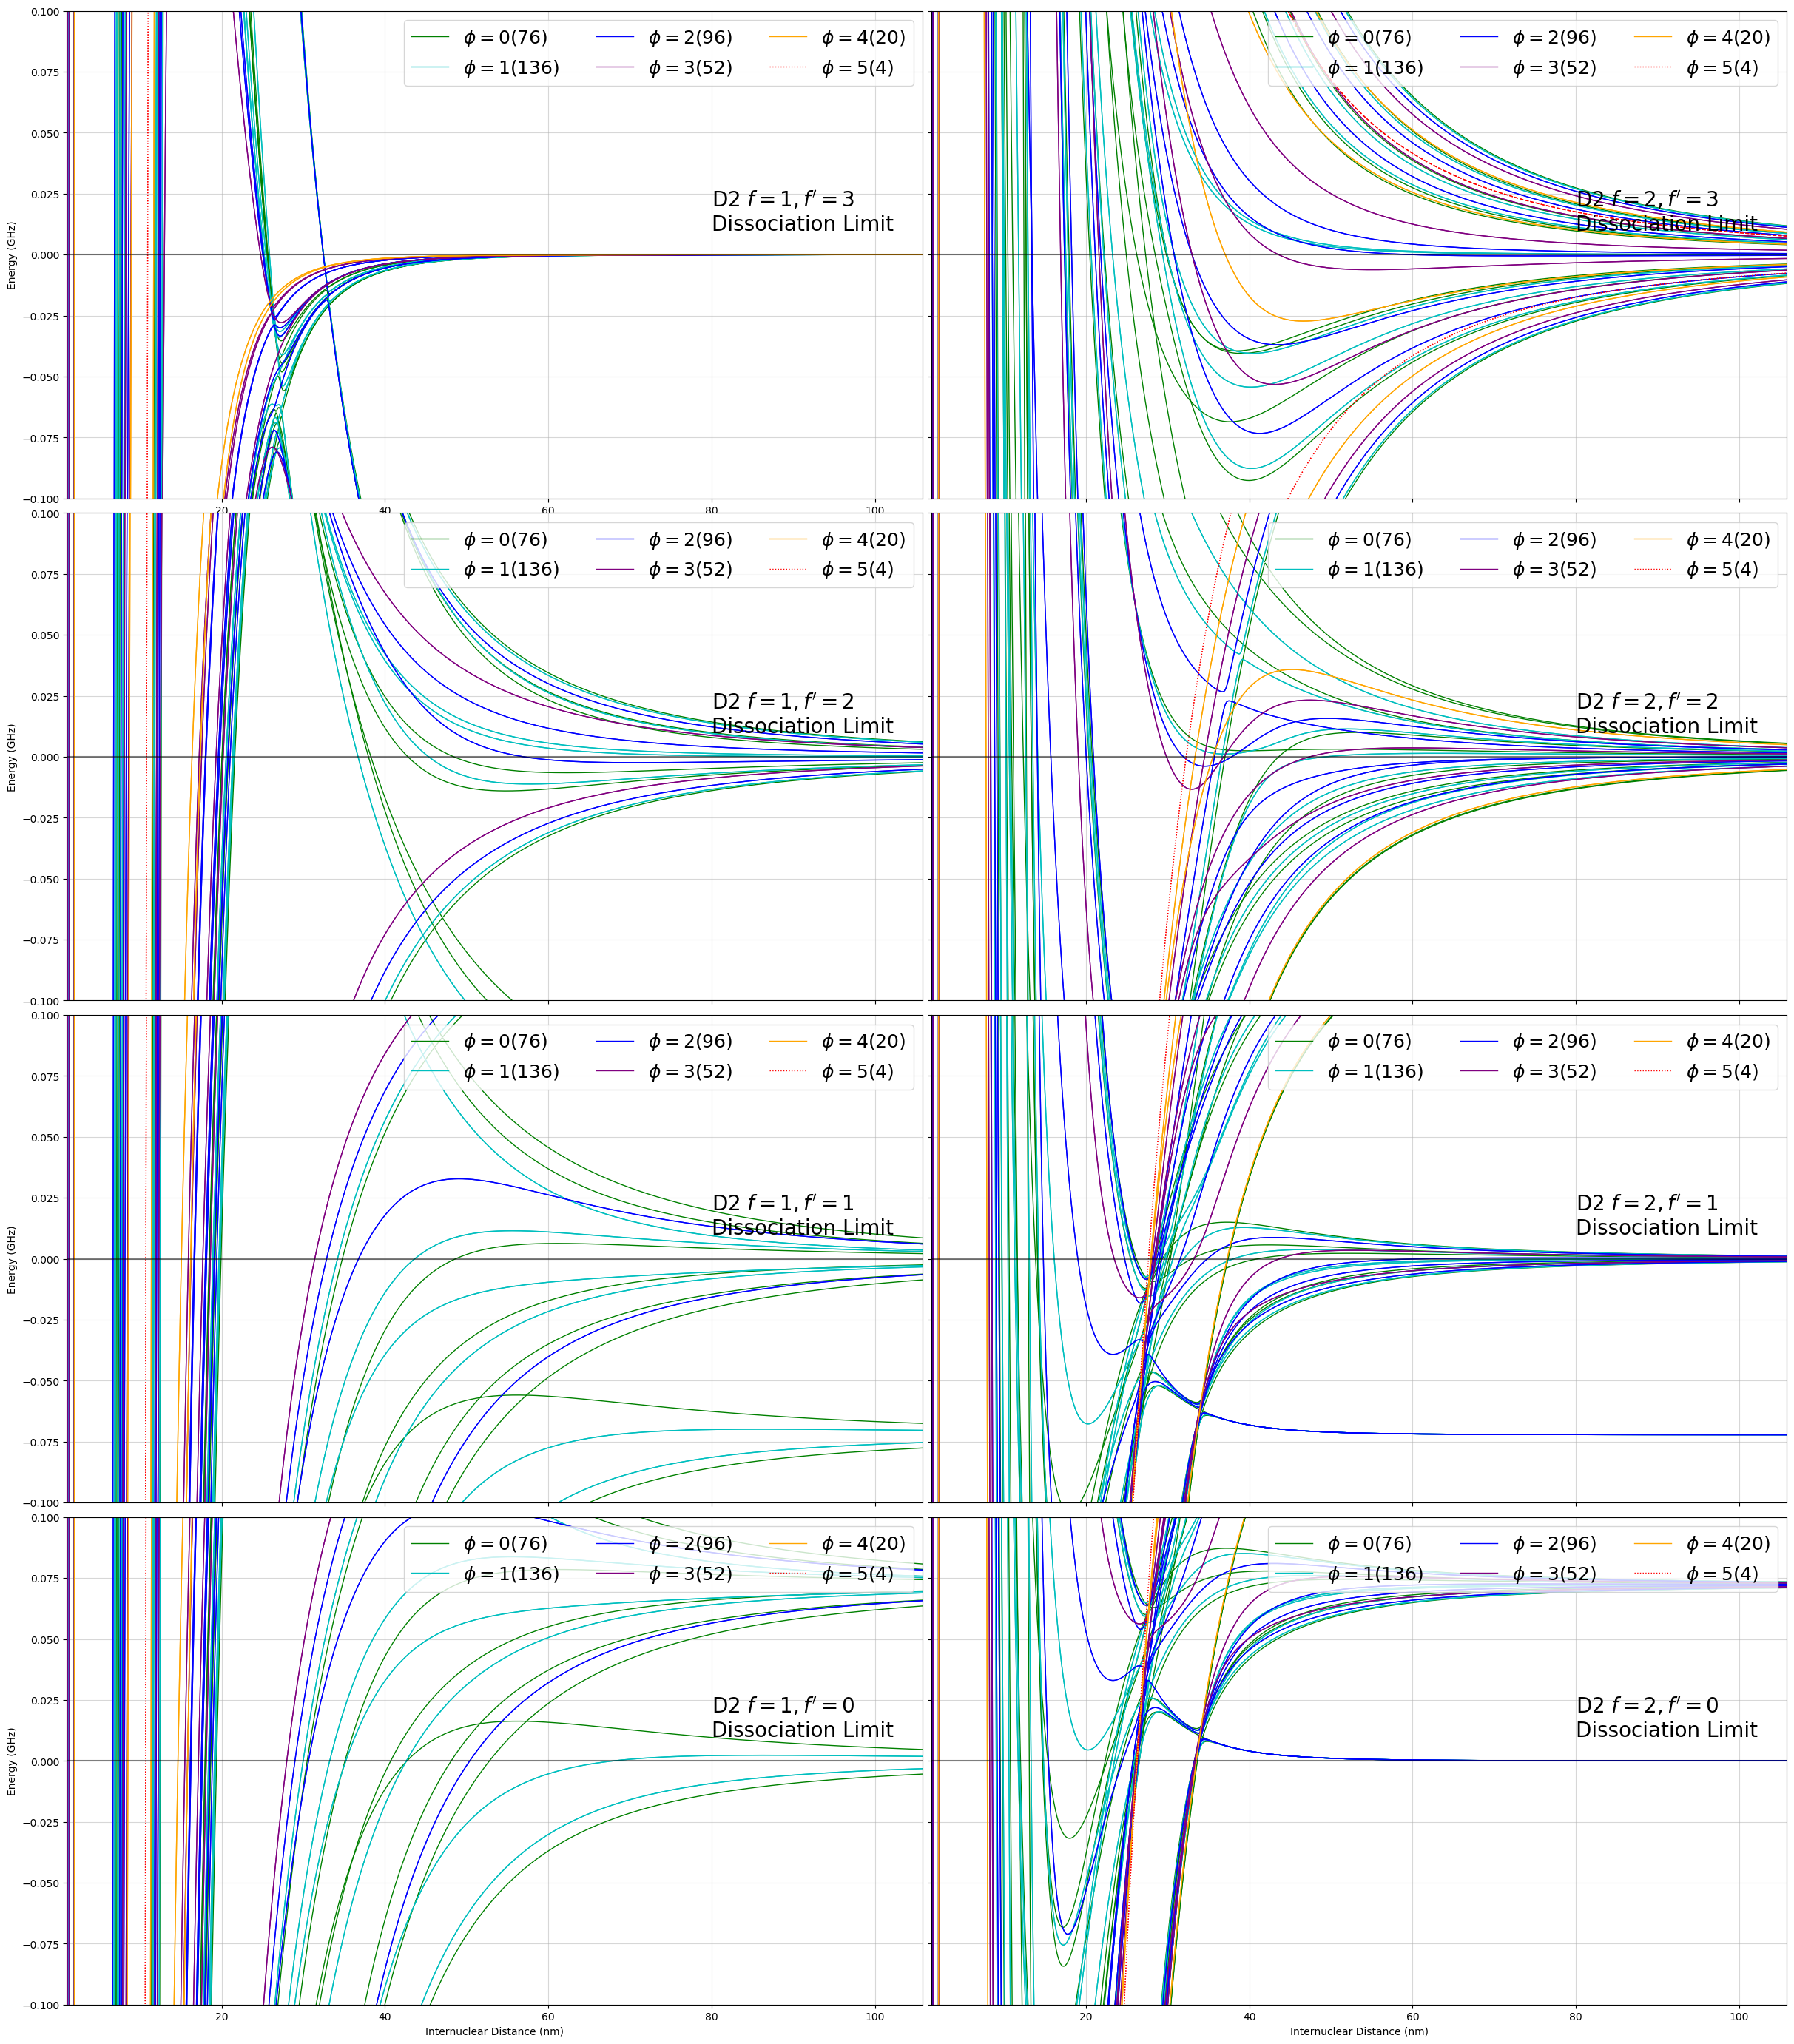

In [61]:
fig = plt.figure(figsize=(30,35))
gs = fig.add_gridspec(4,2)
axs = []
for i1, i2 in zip([0,0,1,1,2,2,3,3], [0,1,0,1,0,1,0,1]):
    axs.append(fig.add_subplot(gs[i1,i2]))
fig.subplots_adjust(hspace=0.03, wspace=0.01)

titles = [
          r"D2 $f=1,f'=3$",r"D2 $f=2,f'=3$",
          r"D2 $f=1,f'=2$",r"D2 $f=2,f'=2$",
          r"D2 $f=1,f'=1$",r"D2 $f=2,f'=1$",
          r"D2 $f=1,f'=0$",r"D2 $f=2,f'=0$"]

allYlims = [
            (-0.1,0.1), (-0.1,0.1),
            (-0.1,0.1), (-0.1,0.1),
            (-0.1,0.1), (-0.1,0.1),
            (-0.1,0.1), (-0.1,0.1),]
gColor = 'r'
uColor = 'orange'
yoffsets = np.array(
            [-mc.Rb87_Ground_ToF1-mc.Rb87_5P32_ToF3,-mc.Rb87_Ground_ToF2-mc.Rb87_5P32_ToF3,
             -mc.Rb87_Ground_ToF1-mc.Rb87_5P32_ToF2,-mc.Rb87_Ground_ToF2-mc.Rb87_5P32_ToF2,
             -mc.Rb87_Ground_ToF1-mc.Rb87_5P32_ToF1,-mc.Rb87_Ground_ToF2-mc.Rb87_5P32_ToF1,
             -mc.Rb87_Ground_ToF1-mc.Rb87_5P32_ToF0,-mc.Rb87_Ground_ToF2-mc.Rb87_5P32_ToF0])/1e9

inc=1
#phiColors, _ = misc.getColors(len(phiBases)+1)#, cmStr='gnuplot')
phiColors=['g','c','b','purple', 'orange','r']
plotByGuCharacter=False
for num, (ax, title, ylims, yoff) in enumerate(zip(axs[:], titles, allYlims, yoffsets)):
    for phiVal, bases in enumerate(phiBases):
        #phiVal=2
        color = phiColors[phiVal]
        for datanum, (mdata, guCharacter) in enumerate(zip(misc.transpose(energies[phiVal])[::inc], misc.transpose(guCharacters[phiVal])[::inc])):
            if plotByGuCharacter:
                points = np.array([Rvals*1e9, np.array(mdata) * 1e-9 / mc.h + yoff]).T.reshape(-1, 1, 2)
                segments = np.concatenate([points[:-1], points[1:]], axis=1)
                lc = LineCollection(segments, cmap='seismic')
                lc.set_array(np.array(guCharacter))
                line = ax.add_collection(lc)
            else:
                ls = '-'
                if np.count_nonzero(guCharacter)==0:
                    ls = '--'
                elif np.count_nonzero(np.array(guCharacter)-1)==0:
                    ls=':'
                ax.plot(Rvals*1e9, np.array(mdata) * 1e-9 / mc.h + yoff , color=color, linestyle=ls, linewidth=1, label=r'$\phi='+str(phiVal)+'('+str(len(bases))+')$' if datanum==0 else None)
    leg = ax.legend(fontsize=18, ncol=3, loc='upper right')
    for text in leg.get_texts():
        text.set_color("k")
    ax.axhline(0,color='k',alpha=0.5)
    ax.text(80,0.01, title + "\nDissociation Limit", fontsize=20, color='k')
    ax.set_ylim(*ylims)
    ax.set_xlim(min(Rvals)*1e9,max(Rvals)*1e9)
    ax.grid(alpha=0.5)
    if num != len(axs)-1 and num != len(axs)-2 and num != 0:
        ax.set_xticklabels([]);
    elif num != 0:
        ax.set_xlabel('Internuclear Distance (nm)')
    if num % 2 == 1:
        ax.set_yticklabels([])
    else:
        ax.set_ylabel('Energy (GHz)')
plt.savefig("Hyperfine_Splitting_D2_Zoom.png", dpi=100, transparent=True, bbox_inches='tight', pad_inches=0)

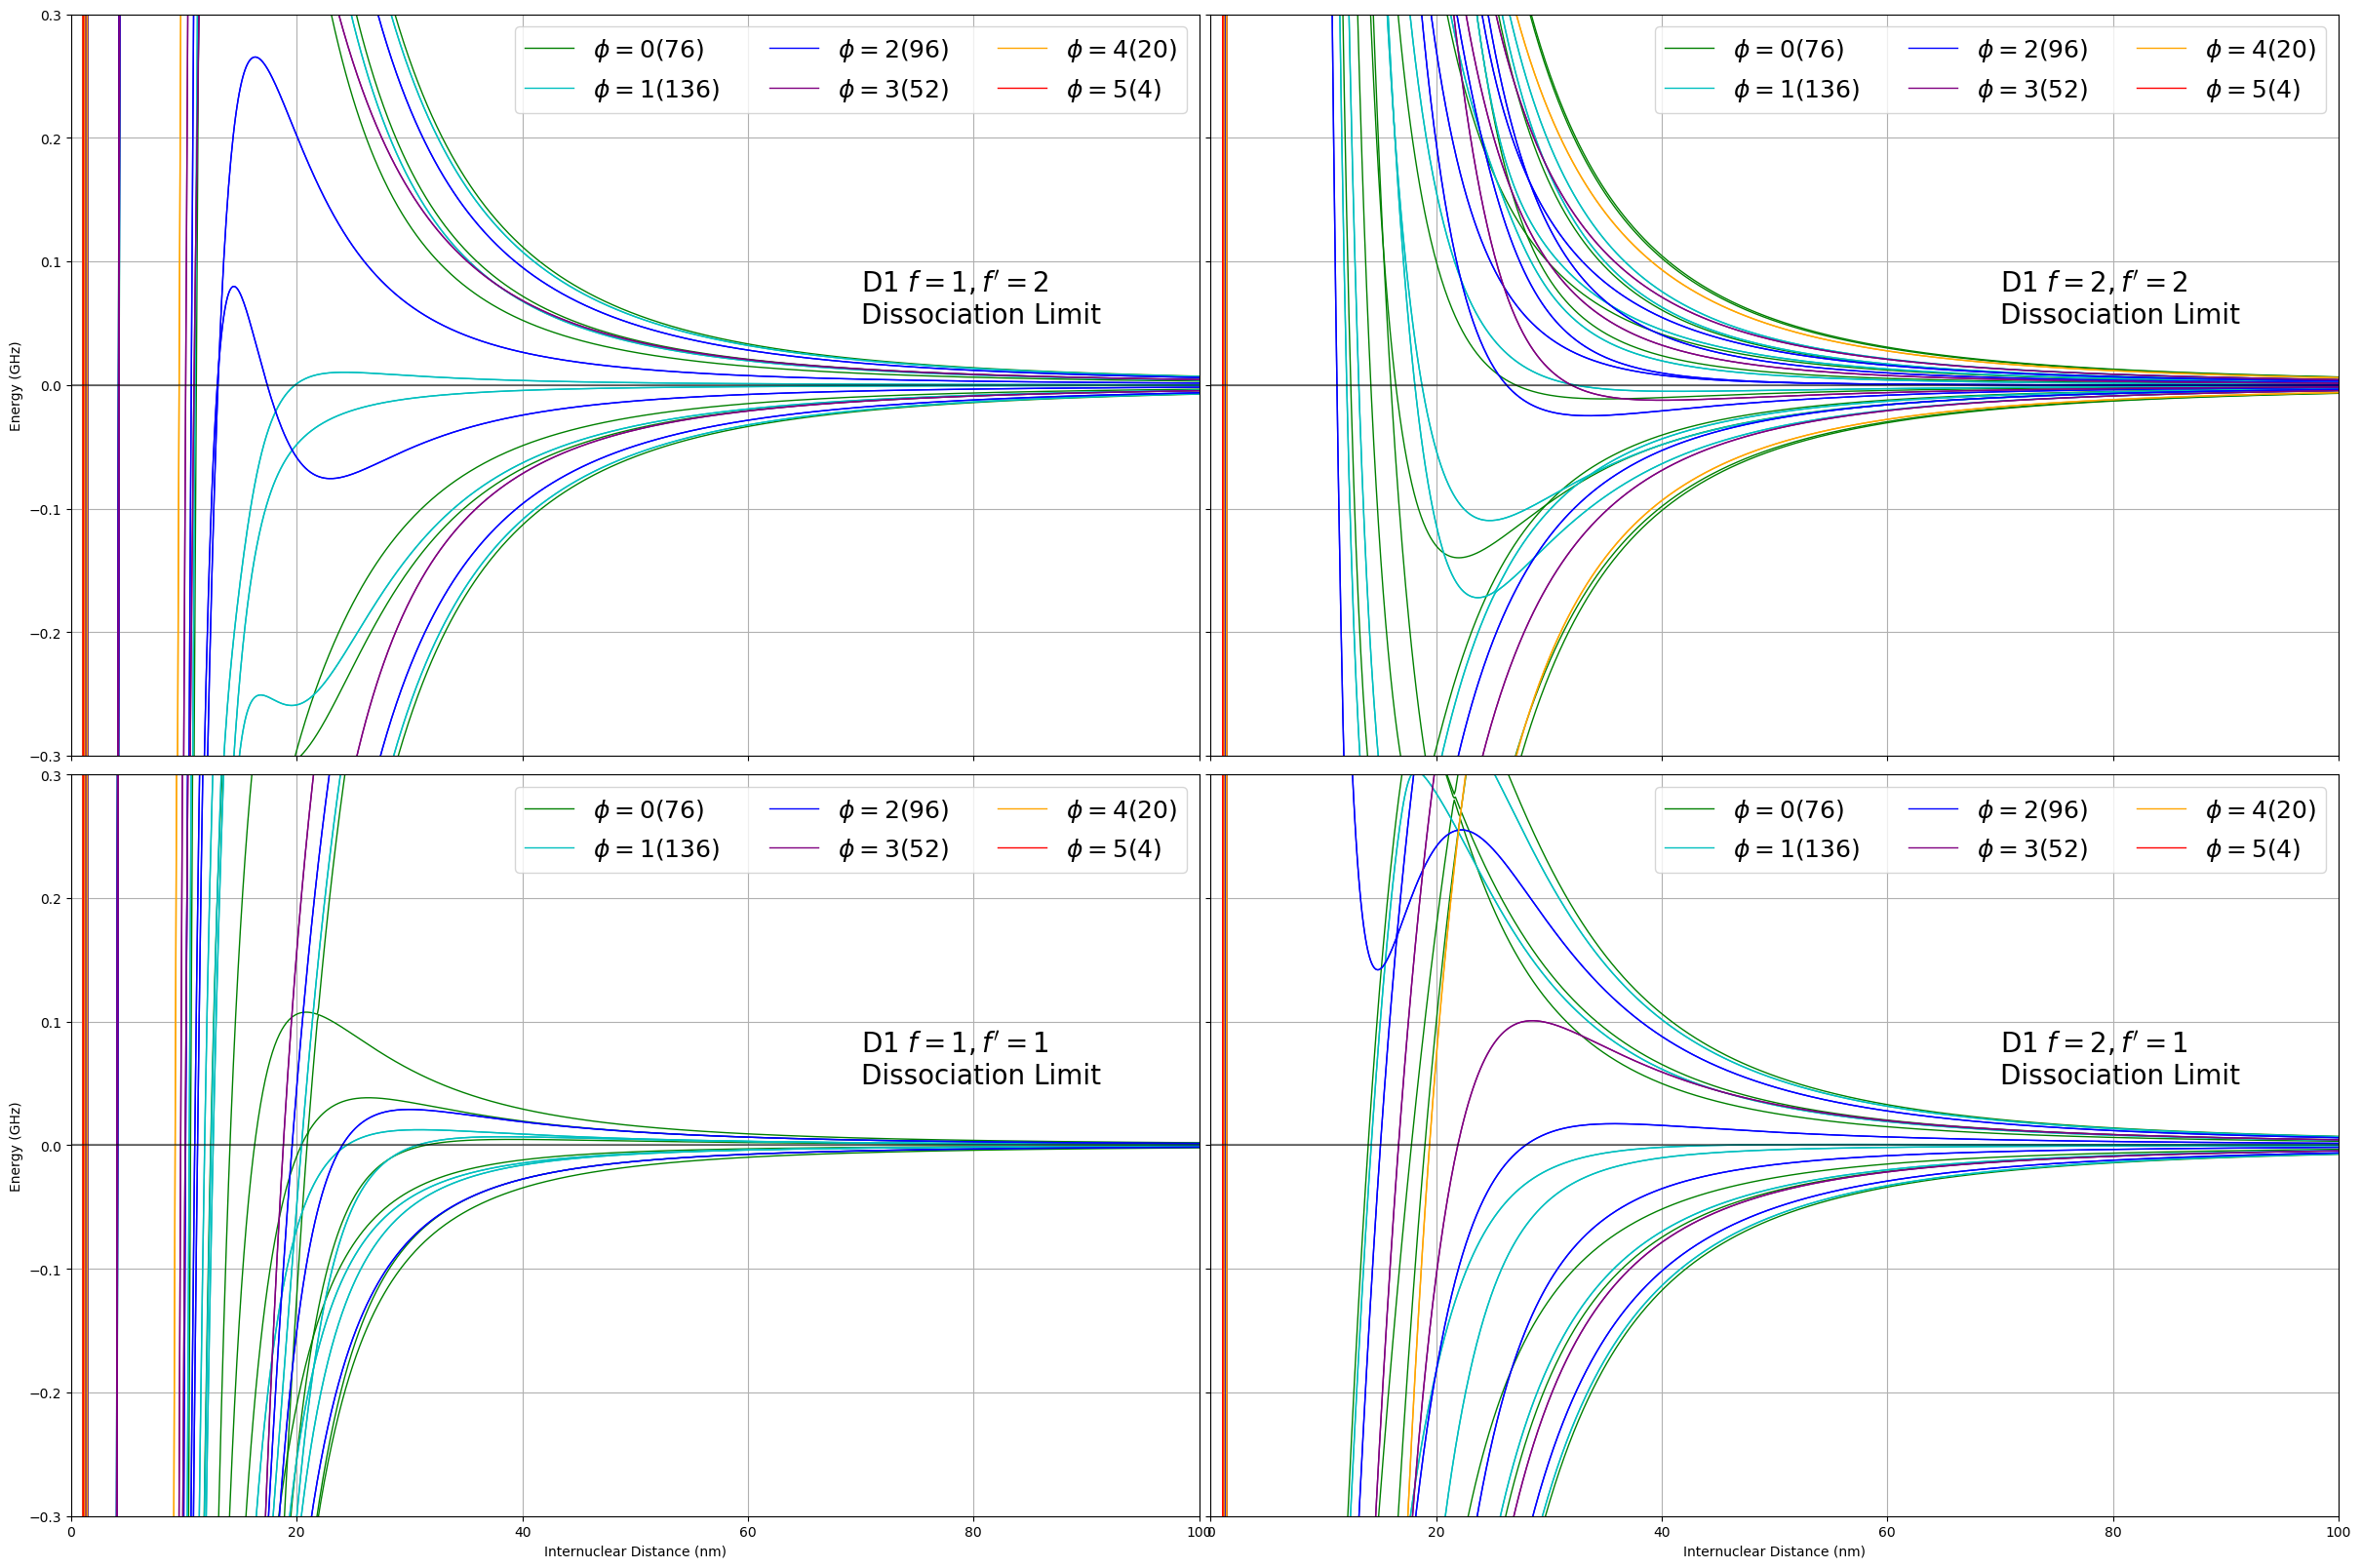

In [62]:
fig = plt.figure(figsize=(30,20))
gs = fig.add_gridspec(2,2)
axs = []
for i1, i2 in zip([0,0,1,1], [0,1,0,1]):
    axs.append(fig.add_subplot(gs[i1,i2]))
fig.subplots_adjust(hspace=0.025, wspace=0.01)

titles = [r"D1 $f=1,f'=2$",r"D1 $f=2,f'=2$",
          r"D1 $f=1,f'=1$",r"D1 $f=2,f'=1$"]

allYlims = np.array(
           [(-0.3,0.3),  (-0.3,0.3),
            (-0.3,0.3),  (-0.3,0.3)])
yoffsets = np.array(         
            [-mc.Rb87_Ground_ToF1-mc.Rb87_5P12_ToF2,-mc.Rb87_Ground_ToF2-mc.Rb87_5P12_ToF2,
             -mc.Rb87_Ground_ToF1-mc.Rb87_5P12_ToF1,-mc.Rb87_Ground_ToF2-mc.Rb87_5P12_ToF1])/1e9
yoffsets += DeltaVal/mc.h/1e9
inc=1
for num, (ax, title, ylims, yoff) in enumerate(zip(axs, titles, allYlims, yoffsets)):
    for phiVal, bases in enumerate(phiBases):
        color = phiColors[phiVal]
        for datanum, (mdata, guCharacter) in enumerate(zip(misc.transpose(energies[phiVal])[::inc], misc.transpose(guCharacters[phiVal])[::inc])):
            """
            points = np.array([Rvals*1e9, np.array(mdata) * 1e-9 / mc.h + yoff]).T.reshape(-1, 1, 2)
            segments = np.concatenate([points[:-1], points[1:]], axis=1)
            lc = LineCollection(segments, cmap='seismic')
            lc.set_array(np.array(guCharacter))
            line = ax.add_collection(lc)
            """
            ax.plot(Rvals*1e9, np.array(mdata) * 1e-9 / mc.h + yoff , color=color, linestyle='-', linewidth=1, label=r'$\phi='+str(phiVal)+'('+str(len(bases))+')$' if datanum==0 else None)
    leg = ax.legend(fontsize=18, ncol=3, loc='upper right')
    for text in leg.get_texts():
        text.set_color("k")

    ax.axhline(0,color='k',alpha=0.5)
    ax.text(70,0.05, title + "\nDissociation Limit", fontsize=20, color='k')
    ax.set_ylim(*ylims)
    ax.set_xlim(0,100)
    ax.grid(alpha=1)
    if num != len(axs)-1 and num != len(axs)-2:
        ax.set_xticklabels([]);
    elif num != 0:
        ax.set_xlabel('Internuclear Distance (nm)')
    if num % 2 == 1:
        ax.set_yticklabels([]);
    else:
        ax.set_ylabel('Energy (GHz)')
plt.savefig("Hyperfine_Splitting_D1_Zoom.png", dpi=100, transparent=True, bbox_inches='tight', pad_inches=0)

# hyperfine w/ rotation

In [67]:
from sympy.physics.secondquant import KroneckerDelta as kd

In [68]:
def br(x):
    return 2*x+1

In [69]:
def coef_hfs(f_a, f_b, f, ell, 
             S, Lambda, Sigma, Omega, I, iota, phi, p, F,
             verbose=False):
    s_a = s_b = 1/2
    i_a = i_b = 3/2
    l_a = 0
    l_b = 1
    L = 1

    sign = int((-1)**(ell-phi-F))
    frac = float((1+(-1)**(1+ell+p)*(1-kd(Lambda,0)*kd(Sigma,0)*kd(iota,0)))
            /sp.sqrt(2-kd(Lambda,0)*kd(Sigma,0)))
    j_a = 1/2
    sumTerm = 0
    cgc3 = float(CG(f,-phi,F,phi,ell,0).doit())
    if cgc3 == 0:
        if verbose:
            print('CG(f,-phi,F,phi,ell,0)=0')
        return 0
    reasonsForZero = []
    for j_b in [1/2,3/2]:
        # no F=3 or F=1 states in the D1 manifold
        if (f_b == 3 or f_b == 0) and j_b == 1/2:
            continue
        
        for j in np.arange(abs(j_b-j_a), j_b+j_a+1,1):
            cgc1 = float(CG(j,Omega,I,iota,f,phi).doit())
            if cgc1 == 0:
                reasonsForZero.append(1)
                continue
            cgc2 = float(CG(L,Lambda,S,Sigma,j,Omega).doit())
            if cgc2 == 0:
                reasonsForZero.append(2)
                continue
            cgcs = cgc1*cgc2*cgc3
            breveTerms = float(np.sqrt(br(1/2)*br(j_b)*br(f_a)
                                 *br(f_b)*br(1)*br(S)*br(j)*br(I)))
            wig1 = float(wigner_9j(l_a, s_a, j_a,
                                   l_b, s_b, j_b, 
                                   L,     S, j))
            if wig1 == 0:
                reasonsForZero.append(3)
                continue
            wig2 = float(wigner_9j(j_a, i_a, f_a,
                                   j_b, i_b, f_b,
                                   j,   I, f))
            if wig2 == 0:
                reasonsForZero.append(4)
                continue;
            reasonsForZero.append(-1)
            sumTerm += breveTerms*cgcs*wig1*wig2
    res = sign*frac*sumTerm
    if res == 0 and verbose:
        print(reasonsForZero)
    if np.isnan(res):
        print('nan!',sign,frac,sumTerm)
    return res

In [187]:
def createCaseE_Basis(F, totalParity):
    IVal = 3/2
    SVal = 1/2
    LVal_e = 1
    jVal_g = 1/2
    caseE_BasisRef = []
    # states with different J have the same rotational energy but it's important for counting the right number of states.
    for jVal_e in np.arange(abs(SVal-LVal_e), SVal+LVal_e+1,1):
        for fVal_e in np.arange(abs(jVal_e-IVal), jVal_e+IVal+1,1):
            for fVal_g in np.arange(abs(jVal_g - IVal), jVal_g+IVal+1,1):
                for f in np.arange(abs(fVal_e-fVal_g),fVal_e+fVal_g+1,1, dtype=int):
                    # max f is 5.
                    for ell in np.arange(max([F-5,0]),F+6,1, dtype=int):
                        if (-1)**ell == totalParity:
                            if F in np.arange(abs(f-ell), f+ell+1,1):
                                state = multiplyableDict({"fa":fVal_g, "fb": fVal_e, "je":jVal_e,"f": f, "ell":ell, 'F':F})
                                if state not in caseE_BasisRef:
                                    caseE_BasisRef.append(state)                                    
    return caseE_BasisRef

In [188]:
def create_EtoA_Matrix(caseA_Basis, caseE_Basis, F):
    print('Creating E-to-A Conversion Matrix')
    res = np.zeros((len(caseA_Basis), len(caseE_Basis)))
    for aind, stateA in enumerate(caseA_Basis):            
        misc.reportProgress(aind, len(caseA_Basis))
        for eind, stateE in enumerate(caseE_Basis):
            p = 0 if (-1)**(F+1)>0 else 1
            res[aind,eind] = coef_hfs(stateE['fa'],stateE['fb'],stateE['f'],stateE['ell'],
                                      stateA['S'],
                                      stateA['Lambda'], stateA['Sigma'], stateA['Omega'], 
                                      stateA['i'], stateA['iota'], stateA['phi'], p, stateE['F'], )
    return res

In [189]:
def createRotationalCouplingMatrix(caseE_Basis):
    # creates the matrix in case E, needs to be transformed to case A basis to calculate properly.
    res = np.zeros((len(caseE_Basis),len(caseE_Basis)))
    for indE, stateE in enumerate(caseE_Basis):
        ell = stateE['ell']
        res[indE,indE] = ell*(ell+1)
    return res

In [34]:
def createBornOppenheimerBasisHFS(Lvals, Svals, Ivals, sigmavals, Fv, totalParity):
    # Normal Notaion is |L Lambda sigma S Sigma>, but I need to keep track of more than that for the splittings caused by other interactions.
    # Therefore this creates a very big basis which is probably unnecessary, but the size of the matrices isn't actually prohibitive in these 
    # calculations so it's okay to have degeneracies.
    #assert (type(Fv)==int and Fv>0)
    assert(type(Fv)==int)
    assert(totalParity == 1 or totalParity == -1)
    
    boBasisRef = []
    for sigma in sigmavals:
        for Lv in Lvals:
            for Lambda in np.arange(-Lv,Lv+1,1):
                for Sv in Svals:
                    for Sigma in np.arange(-Sv, Sv+1,1):
                        for i1 in Ivals:
                            for i2 in Ivals:
                                for Iv in np.arange(abs(i2-i1), i2+i1+1,1):
                                    for iota in np.arange(-Iv,Iv+1,1):
                                        # tells me whether l 
                                        thisParity = (-1)**(Lv+Sv+Iv - Fv)
                                        state = multiplyableDict({"L":Lv, "Lambda": Lambda, "sigma": sigma, "S":Sv, "Sigma":Sigma, "i":Iv, "iota":iota, "i1":i1, "i2":i2,
                                                                  "Omega":Sigma+Lambda, "phi": Sigma+Lambda+iota, 'F':Fv })
                                        if state not in boBasisRef and thisParity == totalParity:
                                            boBasisRef.append(state)
    boBasisRef = list(sorted(boBasisRef, key=lambda state: abs(state["Omega"]) + 100 * ord(state["sigma"])))
    boBasisFancy = []
    for state in boBasisRef:
        spinT = 2*state["S"]+1
        omega = state["Omega"]
        parity = state["sigma"]
        LambdaSymbol = "\Sigma" if state["Lambda"]==0 else "\Pi"
        boBasisFancy.append(Latex(r"$^{"+str(spinT)+ "}" + LambdaSymbol + "_{"+ str(abs(omega)) + "," + parity + "}$"))        
    return boBasisRef, boBasisFancy

In [32]:
A_gs = (mc.Rb87_Ground_ToF2-mc.Rb87_Ground_ToF1)/2
A_12 = (mc.Rb87_5P12_ToF2-mc.Rb87_5P12_ToF1)/2
A_32 = (mc.Rb87_5P32_ToF3-mc.Rb87_5P32_ToF0)/6

In [33]:
lifetime = (mc.Rb87_D1_Lifetime+mc.Rb87_D2_Lifetime)/2
transFreq = 2*np.pi*(mc.Rb87_D2LineFrequency+mc.Rb87_D1LineFrequency)/2
DeltaVal = mc.h*(mc.Rb87_D2LineFrequency-mc.Rb87_D1LineFrequency)# / mc.h
C_3_val = 3*mc.hbar*mc.c**3/(4*lifetime*transFreq**3)# * 1e27 / mc.h
C_3_val = mc.Rb87_C3
print(DeltaVal, C_3_val)

4.7197635548748796e-21 5.94492796981645e-48


In [34]:
lsiBasis, jiBasis, fBasis, lsiBasis2Atom, jiBasis2Atom, fBasis2Atom = createLargerBasisRefs([0,1], [1/2], [3/2])
fsOperator = fsOp(jiBasis2Atom)
hfsOperator = hfsOp(fBasis2Atom, A_12, A_gs, mc.Rb87_5P32_ToF3,mc.Rb87_5P32_ToF2,mc.Rb87_5P32_ToF1,mc.Rb87_5P32_ToF0)
lsiToJiop = lsiToJi(lsiBasis,jiBasis)
jiToFOp = jiTof(jiBasis, fBasis)
fv = 51
boBasisDict_g, boBasisLatex_g = createBornOppenheimerBasisHFS([1],[0,1], [3/2], ['g'], fv, 1)
boBasisDict_u, boBasisLatex_u = createBornOppenheimerBasisHFS([1],[0,1], [3/2], ['u'], fv, 1)
boBasisDict_full, boBasisLatex_full = createBornOppenheimerBasisHFS([1],[0,1], [3/2], ['g', 'u'], fv, 1)

NameError: name 'hfsOp' is not defined

In [ ]:
len(boBasisDict_full)

In [212]:
# Full basis 
numPhi=6
phiBases = [[] for _ in range(numPhi)]
for phi in range(numPhi):
    for state in boBasisDict_full:
        if math.isclose(abs(state['phi']),phi):
            phiBases[phi].append(state)

In [208]:
# LIMITED Basis, not considering degenerate negative phi states
numPhi=6
phiBases = [[] for _ in range(numPhi)]
for phi in range(7):
    for state in boBasisDict_full:
        if state['phi']==phi:
            phiBases[phi].append(state)

In [214]:
[len(b) for b in phiBases]

In [213]:
sum([len(b) for b in phiBases])

In [79]:
H_fs_phi = [[] for _ in phiBases]
H_hfs_phi = [[] for _ in phiBases]
for phiV, phiBase in enumerate(phiBases):
    IPython.display.clear_output(wait=True)
    print('Working on Phi ' + str(phiV) +". " + str(len(phiBase)) + " states")
    
    fsStates = []
    hfsStates = []
    boBasisDict = phiBase
    print('Converting BO states to FS and HFS bases')
    for num, state in enumerate(boBasisDict):
        misc.reportProgress(num, len(boBasisDict))
        sigma = g if state["sigma"] == "g" else u
        I, iota, i1, i2 = [state[k] for k in ["i","iota","i1","i2"]]
        mpstate, indvCont, lsiBasisStates, jiBasisStates = BohrOppenheimerToAtomic( (state["L"], state["Lambda"], 1, 0),
                                                                                   (state["S"], state["Omega"] - state["Lambda"], 1/2, 1/2),
                                                                                   (I, iota, i1, i2), sigma, lsiBasis, basisChange=lsiToJiop )
        hfsState, indvCont, lsiBasisStates, fBasisStates = BohrOppenheimerToAtomic( (state["L"], state["Lambda"], 1, 0),
                                                                                   (state["S"], state["Omega"] - state["Lambda"], 1/2, 1/2), 
                                                                                   (I, iota, i1, i2), sigma, lsiBasis, basisChange=jiToFOp@lsiToJiop )
        if np.isnan(mpstate[0]):
            print("???")
            continue
        fsStates.append(mpstate);
        hfsStates.append(hfsState)
    print('Complete\nCalcualting FS Energies')
    H_fs_phi[phiV] = createCouplingMatrix( fsStates, fsOperator, offset=-1/2)#, boBasis=boBasisDict )
    print('Complete\nCalcualting HFS Energies')
    H_hfs_phi[phiV] = createCouplingMatrix( hfsStates, hfsOperator, offset=0)#, boBasis=boBasisDict )
    print('Complete')

Working on Phi 5. 0 states
Converting BO states to FS and HFS bases
Complete
Calcualting FS Energies
Complete
Calcualting HFS Energies
Complete


In [81]:
import scipy.linalg

In [82]:
allFsPhiE = scipy.linalg.block_diag(*H_fs_phi)
allHfsPhiE = scipy.linalg.block_diag(*H_hfs_phi)

In [84]:
Fvals = [0]
etoaMatrices = [[] for _ in Fvals]
for num, Fval in enumerate(Fvals):
    print('F:', Fval)
    base_E_basis = createCaseE_Basis(Fval, 1)+createCaseE_Basis(Fval, -1)
    etoaMatrices[num] = create_EtoA_Matrix(boBasisDict_full, base_E_basis, Fval);

F: 0
Creating E-to-A Conversion Matrix


In [327]:
Fval = 2
base_E_basis = createCaseE_Basis(Fval, 1)+createCaseE_Basis(Fval, -1)
etoaF2 = create_EtoA_Matrix(boBasisDict_full, base_E_basis, Fval);

Creating E-to-A Conversion Matrix


In [328]:
Fval = 3
base_E_basis = createCaseE_Basis(Fval, 1)+createCaseE_Basis(Fval, -1)
etoaF3 = create_EtoA_Matrix(boBasisDict_full, base_E_basis, Fval);

Creating E-to-A Conversion Matrix


In [333]:
etoaMatrices[2] = etoaF2
etoaMatrices[3] = etoaF3

In [ ]:
Fvals = [0,1,2]
etoaMatrices.append([])
newFVal = 2
base_E_basis = createCaseE_Basis(newFVal, 1)+createCaseE_Basis(newFVal, -1)
etoaMatrices[-1] = create_EtoA_Matrix(boBasisDict_full, base_E_basis, newFVal);

In [806]:
base_E_basis = createCaseE_Basis(0, 1)
etoa = create_EtoA_Matrix(boBasisDict_full, base_E_basis, newFVal);

Creating E-to-A Conversion Matrix


In [807]:
indexes = []
for eind, stateE in enumerate(base_E_basis):
    misc.reportProgress(eind, len(base_E_basis))
    hasProj = False
    for stateA in boBasisDict_full:
        cv = coef_hfs(stateE['fa'],stateE['fb'],stateE['f'],stateE['ell'], 
                       stateA['S'], stateA['Lambda'], stateA['Sigma'], stateA['Omega'], stateA['i'], stateA['iota'], stateA['phi'], p, stateE['F'])
        if cv != 0:
            hasProj = True
    if not hasProj:
        indexes.append(eind)

In [828]:
stateE = base_E_basis[4]
coefs = []
indexes = []
print(stateE)
for aind, stateA in enumerate(boBasisDict_full):
    cv = coef_hfs(stateE['fa'],stateE['fb'],stateE['f'],stateE['ell'], 
                   stateA['S'], stateA['Lambda'], stateA['Sigma'], stateA['Omega'], stateA['i'], stateA['iota'], stateA['phi'], p, stateE['F'])
    if cv != 0:
        coefs.append(cv)
        indexes.append(aind)
        print(stateA)

{'fa': 2.0, 'fb': 2.0, 'je': 0.5, 'f': 0, 'ell': 0, 'F': 0}
{'L': 1, 'Lambda': 0, 'sigma': 'g', 'S': 0, 'Sigma': 0, 'i': 1.0, 'iota': 0.0, 'i1': 1.5, 'i2': 1.5, 'Omega': 0, 'phi': 0.0}
{'L': 1, 'Lambda': 0, 'sigma': 'g', 'S': 1, 'Sigma': 0, 'i': 0.0, 'iota': -0.0, 'i1': 1.5, 'i2': 1.5, 'Omega': 0, 'phi': 0.0}
{'L': 1, 'Lambda': 0, 'sigma': 'g', 'S': 1, 'Sigma': 0, 'i': 2.0, 'iota': 0.0, 'i1': 1.5, 'i2': 1.5, 'Omega': 0, 'phi': 0.0}
{'L': 1, 'Lambda': 0, 'sigma': 'u', 'S': 0, 'Sigma': 0, 'i': 1.0, 'iota': 0.0, 'i1': 1.5, 'i2': 1.5, 'Omega': 0, 'phi': 0.0}
{'L': 1, 'Lambda': 0, 'sigma': 'u', 'S': 1, 'Sigma': 0, 'i': 0.0, 'iota': -0.0, 'i1': 1.5, 'i2': 1.5, 'Omega': 0, 'phi': 0.0}
{'L': 1, 'Lambda': 0, 'sigma': 'u', 'S': 1, 'Sigma': 0, 'i': 2.0, 'iota': 0.0, 'i1': 1.5, 'i2': 1.5, 'Omega': 0, 'phi': 0.0}


In [829]:
print(sum([val**2 for val in coefs]))

1.233333333333333


In [811]:
print(etoa.shape)
ide = etoa@etoa.T
ide2 = etoa.T@etoa
print(ide.shape, ide2.shape)

(384, 19)
(384, 384) (19, 19)


In [ ]:
Rvals = np.linspace( 1*20*mc.a0, 100*20*mc.a0, 5000 )
colors = ['y','r','b','g']
Fvals = [0,1,2,3]
superdata = [[] for _ in Fvals]
for Fvalnum, (Fval, color) in enumerate(zip(Fvals, colors)):
    data = superdata[Fvalnum]
    base_E_basis = createCaseE_Basis(Fval, 1)+createCaseE_Basis(Fval, -1)
    RCM = createRotationalCouplingMatrix(base_E_basis)*mc.Rb87_M*1e-9**2/(mc.hbar**2)
    print(RCM.shape,np.array(etoaMatrices[Fvalnum]).shape)    
    #etoa = create_EtoA_Matrix(boBasisDict_full, base_E_basis, Fval);
    rotationalEnergy = etoaMatrices[Fvalnum]@RCM@etoaMatrices[Fvalnum].conj().T
    print("Diagonalizing Energy at all R.")
    for rnum, rv in enumerate(Rvals):
        misc.reportProgress(rnum, len(Rvals))
        t1 = createBOMatrix2(C_3_val, rv, *boBasisDict_full).astype(float)
        t2 = allFsPhiE * 2 * DeltaVal / 3
        t3 = allHfsPhiE * mc.h
        rmatrix = t1+t2+t3+rotationalEnergy
        data.append(sorted(np.real(np.linalg.eigvalsh(rmatrix))))
        #eigVals, eigVectors = np.linalg.eigh(rmatrix)

In [ ]:
fig = plt.figure(figsize=(30,20))
gs = fig.add_gridspec(2,2)
axs = []
for i1, i2 in zip([0,0,1,1], [0,1,0,1]):
    axs.append(fig.add_subplot(gs[i1,i2]))
fig.subplots_adjust(hspace=0.025, wspace=0.01)

titles = [r"D1 $f=1,f'=2$",r"D1 $f=2,f'=2$",
          r"D1 $f=1,f'=1$",r"D1 $f=2,f'=1$"]

allYlims = np.array(
           [(-0.3,0.3),  (-0.3,0.3),
            (-0.3,0.3),  (-0.3,0.3)])
yoffsets = np.array(         
            [-mc.Rb87_Ground_ToF1-mc.Rb87_5P12_ToF2,-mc.Rb87_Ground_ToF2-mc.Rb87_5P12_ToF2,
             -mc.Rb87_Ground_ToF1-mc.Rb87_5P12_ToF1,-mc.Rb87_Ground_ToF2-mc.Rb87_5P12_ToF1])/1e9
yoffsets += DeltaVal/mc.h/1e9
inc=1
colors, _ = misc.getColors(len(superdata)+1)
for num, (ax, title, ylims, yoff) in enumerate(zip(axs, titles, allYlims, yoffsets)):
    for data, color in zip(superdata, colors):
        for datanum, mdata in enumerate(misc.transpose(data)):
            ax.plot(Rvals*1e9, np.array(mdata) * 1e-9 / mc.h + yoff , color=color, linestyle='-', linewidth=1)
    #leg = ax.legend(fontsize=18, ncol=3, loc='upper right')
    for text in leg.get_texts():
        text.set_color("k")

    ax.axhline(0,color='k',alpha=0.5)
    ax.text(70,0.05, title + "\nDissociation Limit", fontsize=20, color='k')
    ax.set_ylim(*ylims)
    ax.set_xlim(0,100)
    ax.grid(alpha=1)
    if num != len(axs)-1 and num != len(axs)-2:
        ax.set_xticklabels([]);
    elif num != 0:
        ax.set_xlabel('Internuclear Distance (nm)')
    if num % 2 == 1:
        ax.set_yticklabels([]);
    else:
        ax.set_ylabel('Energy (GHz)')
#plt.savefig("Hyperfine_Splitting_D1_Zoom.png", dpi=100, transparent=True, bbox_inches='tight', pad_inches=0)

In [ ]:
fig, axs = plt.subplots(3,2,figsize=(30,15))
for fvalnum, (Fval, color) in enumerate(zip(Fvals, colors)):
    data = superdata[Fvalnum]
    for ax in axs.flatten():
        #ax.axhline(-0.0729113, alpha=0.2,color='r')
        #ax.axhline(-0.2298518, alpha=0.2,color='r')
        #ax.axhline(-0.30207388, alpha=0.2,color='r')
        #ax.axhline(-DeltaVal* 1e-9 / mc.h+0.306246, alpha=0.2,color='r')
        #ax.axhline(-DeltaVal* 1e-9 / mc.h-0.510410, alpha=0.2,color='r')
        for mdata in misc.transpose(data):
            ax.plot(Rvals*1e9, np.array(mdata) * 1e-9 / mc.h, color=color, linestyle='-')
        ax.set_xlabel('Inter-nuclear distance (nm)')
        ax.set_ylabel('Energy (GHz)')
        ax.grid(alpha=0.1)
        ax.axhline(0.1937408, alpha=0.2,color='r', label='F States')

    axs[0,0].set_title('Full Range')
    axs[0,0].set_xlim(min(Rvals)*1e9,max(Rvals)*1e9/20)
    #axs[0,0].legend(ncol=5,fontsize=14)s
    axs[1,0].set_title('Zoom $5P_{3/2}$')
    axs[1,0].set_xlim(min(Rvals)*1e9,max(Rvals)*1e9/10)
    axs[1,0].set_ylim(-1000, 500)
    axs[0,1].set_title('Super-Zoom $5P_{3/2}""$')
    axs[0,1].set_xlim(min(Rvals)*1e9,max(Rvals)*1e9)
    axs[0,1].set_ylim(-0.35, 0.25)
    axs[1,1].set_title('Zoom $5P_{1/2}$')
    axs[1,1].set_xlim(min(Rvals)*1e9,max(Rvals)*1e9/10)
    axs[1,1].set_ylim(-8000, -6000);
    axs[2,0].set_xlim(1.41,1.42)
    axs[2,0].set_ylim(-3170,-3160)
    axs[2,1].set_xlim(min(Rvals)*1e9, max(Rvals)*1e9)
    #plt.savefig('Movre-Pischler-Super-Rotating.png', dpi=200)

In [ ]:
Rvals = np.linspace( 1*20*mc.a0, 100*20*mc.a0, 1000 )

energies = [np.zeros((len(Rvals),len(phiBase))) for phiBase in phiBases]
guCharacters = [np.zeros((len(Rvals),len(phiBase))) for phiBase in phiBases]
phiCharacter = [np.zeros((len(Rvals),len(phiBase))) for phiBase in phiBases]
pCharacter = [np.zeros((len(Rvals),len(phiBase))) for phiBase in phiBases]

for phi, base in enumerate(phiBases):
    if len(base) == 0:
        continue
    IPython.display.clear_output(wait=True)
    print('\nPhiVal:',phi)
    print('Calcualting Eigenvalues at every R')    
    boBasisDict = base
    for num, rv in enumerate(Rvals):
        misc.reportProgress(num, len(Rvals))
        rmatrix = createBOMatrix2(C_3_val, rv, *boBasisDict).astype(float) + H_fs_phi[phi] * 2 * DeltaVal / 3 + H_hfs_phi[phi] * mc.h
        eigVals, eigVectors = np.linalg.eigh(rmatrix)
        guCharacterIndvR  = np.zeros(len(boBasisDict))
        pCharIndvR = np.zeros(len(boBasisDict))
        for vnum, eigVec in enumerate(misc.transpose(eigVectors)):
            for stateCoef, state in zip(eigVec, boBasisDict):
                pCharIndvR[vnum] += stateCoef**2*(-1)**state['i']
                if state['sigma']=='u':
                    guCharacterIndvR[vnum] += stateCoef**2
                else:
                    assert(state['sigma']=='g')
        tups = zip(eigVals, eigVectors, guCharacterIndvR);
        tups = sorted(tups, key=lambda v: v[0]/mc.h + v[2])
        eigVals, eigVectors, guCharacterIndvR = zip(*tups)
        energies[phi][num] = eigVals
        guCharacters[phi][num] = guCharacterIndvR
        pCharacter[phi][num] = pCharIndvR

$$
v_{th} = \sqrt{\frac{3k_B T}{m}}
$$

In [194]:
T = 1000e-6
v_th = np.sqrt((3*mc.k_B*T)/mc.Rb87_M)
print('velocity: ' + misc.round_sig_str(v_th) + ' m/s')
print('distance traveled during lifetime: ' + misc.round_sig_str(v_th*mc.Rb87_D1_Lifetime*1e9) + ' nm')

velocity: 0.536 m/s
distance traveled during lifetime: 14.8 nm


### testing fine structure result from paul

In [830]:
import sympy as sp

In [831]:
def getMatrix1(Jv):
    matrix = np.zeros((6,6))
    Norm = 1/sp.sqrt(6*(2*Jv+1))
    matrix = sp.Matrix(matrix)
    matrix[:,0] = [  2*Jv,   4*Jv,   2*Jv+2,    -2*Jv-2,  2*Jv+2,  0]
    matrix[:,1] = [ -2*Jv-2,-4*Jv-4, 2*Jv,      -2*Jv,    2*Jv,    0]
    matrix[2] = [  4*Jv,  -2*Jv,   4*Jv+4,     Jv+1,   -Jv-1,    0]
    matrix[3] = [ -4*Jv-4, 2*Jv+2, 4*Jv,       Jv,     -Jv,      0]
    matrix[4] = [ 0,       0,      0,         -3*Jv+3, -3*Jv+3, -6*Jv-12]
    matrix[5] = [ 0,       0,      0,          3*Jv+6,  3*Jv+6, -6*Jv+6]
    if Jv==0:
        matrix[0] = 0
        matrix[2] = 0
        matrix[4] = 0
        matrix[5] = 0
        matrix[:,2] = 0
        matrix[:,3] = 0
        matrix[:,4] = 0
        matrix[:,5] = 0
    if Jv == 1:
        matrix[4] = 0
        matrix[:,5] = 0
    for ri in range(matrix.rows):
        for ci in range(matrix.cols):
            val = matrix[ri,ci]
            matrix[ri,ci] = np.sign(val.subs({Jv:10}))*sp.sqrt(sp.Abs(val))
    return (matrix*Norm).T

In [832]:
Jv = sp.symbols('J',positive=True)
Jv = Jv+1
res = getMatrix1(Jv)

In [833]:
def getMatrix2(Jv):
    matrix = np.zeros((6,6))
    matrix = sp.Matrix(matrix)
    Cv = (2*Jv+3)*(2*Jv-1)
    Dv = (2*Jv+3)*(2*Jv+1)
    Ev = 4*Jv**2-1
    matrix[0] = [ sp.S(1)/3, -sp.S(2)/3, 0, 0, 0, 0 ]
    matrix[1] = [ 0, 0, (-1)**Jv/3,   -(-1)**Jv/3,  (-1)**Jv/3, 0 ]
    matrix[2] = [ 0, 0, (-1)**Jv*2/3,  (-1)**Jv/6, -(-1)**Jv/6, 0]
    matrix[3] = [    Jv*(Jv-1) /Ev,      Jv*(Jv-1)   /(2*Ev), 0,  Jv*(Jv-1)/Ev,     Jv*(Jv-1)/Ev,       (Jv+1)*(Jv+2)/(2*Ev) ]
    matrix[4] = [ -2*Jv*(Jv+1) /(3*Cv), -Jv*(Jv+1)   /(3*Cv), 0,         -3/(2*Cv),        -3/(2*Cv), 3*(Jv-1)*(Jv+2)/Cv ]
    matrix[5] = [ (Jv+1)*(Jv+2)/Dv,     (Jv+1)*(Jv+2)/(2*Dv), 0, -Jv*(Jv+2)/Dv,    -Jv*(Jv+2)/Dv,           Jv*(Jv-1)/(2*Dv)]
    if Jv == 0:
        matrix[1] = 0
        matrix[2] = 0
        matrix[3] = 0
        matrix[4] = 0 
        matrix[:,2] = 0
        matrix[:,3] = 0
        matrix[:,4] = 0
        matrix[:,5] = 0
    if Jv == 1:
        matrix[3] = 0
        matrix[:,5] = 0
    
    for ri in range(matrix.rows):
        for ci in range(matrix.cols):
            val = matrix[ri,ci]
            matrix[ri,ci] = np.sign(val.subs({Jv:10}))*sp.sqrt(sp.Abs(val))
    return matrix.T

In [834]:
res = getMatrix2(Jv)

In [ ]:
(res.T*res).subs({Jv:2})

In [836]:
def HRotOverB_case_e_1(Jv):
    Hr = sp.Matrix(np.zeros((6,6)))
    el = Jv-1
    Hr[0,0] = el*(el+1)
    el = Jv+1
    Hr[1,1] = el*(el+1)
    el = Jv-1
    Hr[2,2] = el*(el+1)
    el = Jv+1
    Hr[3,3] = el*(el+1)
    el = Jv-1
    Hr[4,4] = el*(el+1)
    el = Jv+1
    Hr[5,5] = el*(el+1)
    return Hr

In [837]:
def HRotOverB_case_e_2(Jv):
    Hr = sp.Matrix(np.zeros((6,6)))
    el = Jv
    sp.assuming()
    Hr[0,0] = el*(el+1)
    el = Jv
    Hr[1,1] = el*(el+1)
    el = Jv
    Hr[2,2] = el*(el+1)
    el = Jv-2
    Hr[3,3] = el*(el+1)
    el = Jv
    Hr[4,4] = el*(el+1)
    el = Jv+2
    Hr[5,5] = el*(el+1)
    return Hr

In [838]:
Jv = sp.symbols('J', real=True, positive=True)
S_ea = getMatrix1(Jv+1)
Hr = HRotOverB_case_e_1(Jv+1)
res = sp.simplify(S_ea.T*Hr*S_ea)

In [ ]:
display(res)
display(res.subs({Jv:10}))

In [840]:
Jv = sp.symbols('J', real=True, positive=True)
S_ea = getMatrix2(Jv+1)
Hr = HRotOverB_case_e_2(Jv+1)
res = sp.simplify(S_ea.T*Hr*S_ea)

In [ ]:
(S_ea.T@S_ea).subs({Jv:5}).evalf()

In [ ]:
#display(res)
display(res.subs({Jv:4}))
display(res.subs({Jv:4}).evalf())

In [843]:
np.sqrt(2*(4*(4+1)-2))

In [844]:
Jv = 3
S_ea = getMatrix2(Jv)
#print(S_ea**2)
#print(S_ea)
Hr = HRotOverB_case_e_2(Jv)
#print(Hr)
print(S_ea.T)
print(Hr@S_ea)

#print(S_ea.T@Hr@S_ea)

Matrix([[sqrt(3)/3, 0, 0, 0.414039335605413, -0.421637021355784, 0.563436169819011], [-sqrt(6)/3, 0, 0, 0.292770021884560, -0.298142396999972, 0.398409536444798], [0, -0.577350269189626, -0.816496580927726, 0, 0, 0], [0, 0.577350269189626, -0.408248290463863, 0.414039335605413, -0.182574185835055, -0.487950036474267], [0, -0.577350269189626, 0.408248290463863, 0.414039335605413, -0.182574185835055, -0.487950036474267], [0, 0, 0, 0.534522483824849, 0.816496580927726, 0.218217890235992]])
Matrix([[4*sqrt(3), -4*sqrt(6), 0, 0, 0, 0], [0, 0, -6.92820323027551, 6.92820323027551, -6.92820323027551, 0], [0, 0, -9.79795897113271, -4.89897948556636, 4.89897948556636, 0], [0.828078671210825, 0.585540043769120, 0, 0.828078671210825, 0.828078671210825, 1.06904496764970], [-5.05964425626941, -3.57770876399966, 0, -2.19089023002066, -2.19089023002066, 9.79795897113271], [16.9030850945703, 11.9522860933439, 0, -14.6385010942280, -14.6385010942280, 6.54653670707977]])


In [845]:
Jv=3
(Jv-2)*(Jv-1)*np.sqrt(Jv*(Jv-1)/(4*Jv**2-1))

#### work space

In [ ]:
indexes = []
for eind, stateE in enumerate(base_E_basis):
    misc.reportProgress(eind, len(base_E_basis))
    hasProj = False
    for stateA in boBasisDict_full:
        cv = coef_hfs(stateE['fa'],stateE['fb'],stateE['f'],stateE['ell'], 
                       stateA['S'], stateA['Lambda'], stateA['Sigma'], stateA['Omega'], stateA['i'], stateA['iota'], stateA['phi'], p, stateE['F'])
        if cv != 0:
            hasProj = True
    if not hasProj:
        indexes.append(eind)

In [803]:
stateE = base_E_basis[-1]
print(stateE)
for stateA in boBasisDict_full:
    cv = coef_hfs( stateE['fa'],stateE['fb'],stateE['f'],stateE['ell'], 
                   stateA['S'], stateA['Lambda'], stateA['Sigma'], stateA['Omega'], stateA['i'], stateA['iota'], stateA['phi'], p, stateE['F'] )
    if cv != 0:
        print(stateA)

{'fa': 2.0, 'fb': 3.0, 'je': 1.5, 'f': 4, 'ell': 4, 'F': 0}
{'L': 1, 'Lambda': 0, 'sigma': 'g', 'S': 0, 'Sigma': 0, 'i': 3.0, 'iota': 0.0, 'i1': 1.5, 'i2': 1.5, 'Omega': 0, 'phi': 0.0}
{'L': 1, 'Lambda': 0, 'sigma': 'g', 'S': 1, 'Sigma': 0, 'i': 2.0, 'iota': 0.0, 'i1': 1.5, 'i2': 1.5, 'Omega': 0, 'phi': 0.0}
{'L': 1, 'Lambda': 0, 'sigma': 'u', 'S': 0, 'Sigma': 0, 'i': 3.0, 'iota': 0.0, 'i1': 1.5, 'i2': 1.5, 'Omega': 0, 'phi': 0.0}
{'L': 1, 'Lambda': 0, 'sigma': 'u', 'S': 1, 'Sigma': 0, 'i': 2.0, 'iota': 0.0, 'i1': 1.5, 'i2': 1.5, 'Omega': 0, 'phi': 0.0}


In [786]:
for ind in indexes:
    print(base_E_basis[ind])

{'fa': 1.0, 'fb': 3.0, 'je': 1.5, 'f': 2, 'ell': 2, 'F': 0}
{'fa': 1.0, 'fb': 3.0, 'je': 1.5, 'f': 4, 'ell': 4, 'F': 0}
{'fa': 2.0, 'fb': 3.0, 'je': 1.5, 'f': 2, 'ell': 2, 'F': 0}
{'fa': 2.0, 'fb': 3.0, 'je': 1.5, 'f': 4, 'ell': 4, 'F': 0}


# Misc

## Alkali-Earths

In [21]:
lsBasis, jBasis, lsBasis2, jBasis2 = createBasisRefs([0,1], [1,0])
fsOperator = fsOp(jBasis2)

In [22]:
# 0g
sig_3mg_0g = BohrOppenheimerToAtomic( (1, 0, 1, 0), (1, 0, 1, 0), g, lsBasis, jBasis );
pi_3g_0g   = 2**(-1/2)*( BohrOppenheimerToAtomic( (1, -1, 1, 0), (1, 1, 1, 0), g, lsBasis, jBasis )
                         +BohrOppenheimerToAtomic( (1, 1, 1, 0), (1, -1, 1, 0), g, lsBasis, jBasis ))
pi_3g_0g2   = 2**(-1/2)*( BohrOppenheimerToAtomic( (1, -1, 1, 0), (1, 1, 1, 0), g, lsBasis, jBasis )
                         -BohrOppenheimerToAtomic( (1, 1, 1, 0), (1, -1, 1, 0), g, lsBasis, jBasis ))
bo_0g = [(1,0,1,0,g),(1,-1,1,1,g), (1,-1,1,1,g)]
# 0u
sig_3mu_0u = BohrOppenheimerToAtomic( (1, 0, 1, 0), (1, 0, 1, 0), u, lsBasis, jBasis );
pi_3u_0u   = 2**(-1/2)*( BohrOppenheimerToAtomic( (1, -1, 1, 0), (1, 1, 1, 0), u, lsBasis, jBasis )
                         +BohrOppenheimerToAtomic( (1, 1, 1, 0), (1, -1, 1, 0), u, lsBasis, jBasis ))
pi_3u_0u2   = 2**(-1/2)*( BohrOppenheimerToAtomic( (1, -1, 1, 0), (1, 1, 1, 0), u, lsBasis, jBasis )
                         -BohrOppenheimerToAtomic( (1, 1, 1, 0), (1, -1, 1, 0), u, lsBasis, jBasis ))
bo_0u = [(1,0,1,0,g),(1,-1,1,1,g), (1,-1,1,1,g)]
# 1g
sig_3g_1g = BohrOppenheimerToAtomic( (1, 0, 1, 0), (1, 1, 1, 0), g, lsBasis, jBasis );
pi_3g_1g  = BohrOppenheimerToAtomic( (1, 1, 1, 0), (1, 0, 1, 0), g, lsBasis, jBasis );
bo_1g = [(1,0,1,1,g),(1,1,1,0,g)]
# 1u
pi_3u_1u  = BohrOppenheimerToAtomic( (1, 1, 1, 0), (1, 0, 1, 0), u, lsBasis, jBasis );
sig_3u_1u = BohrOppenheimerToAtomic( (1, 0, 1, 0), (1, 1, 1, 0), u, lsBasis, jBasis );
bo_1u = [(1,0,1,1,u),(1,1,1,0,u)]
# 2g
pi_3g_2g = BohrOppenheimerToAtomic( (1, 1, 1, 0), (1, 1, 1, 0), g, lsBasis, jBasis );
bo_2g = [(1,1,1,1,g)]
# 2u
pi_3u_2u = BohrOppenheimerToAtomic( (1, 1, 1, 0), (1, 1, 1, 0), u, lsBasis, jBasis );
bo_2u = [(1,1,1,1,u)]

In [23]:
V_0g = createMovrePichlerMatrix((sig_3mg_0g, pi_3g_0g, pi_3g_0g2), fsOperator, offset=0)
V_0u = createMovrePichlerMatrix((sig_3mu_0u, pi_3u_0u, pi_3u_0u2), fsOperator, offset=0)
V_1g = createMovrePichlerMatrix((pi_3g_1g, sig_3g_1g), fsOperator, offset=0)
V_1u = createMovrePichlerMatrix((pi_3u_1u, sig_3u_1u), fsOperator, offset=0)
V_2g = createMovrePichlerMatrix((pi_3g_2g, ), fsOperator, offset=0)
V_2u = createMovrePichlerMatrix((pi_3u_2u, ), fsOperator, offset=0)

In [24]:
SrDeltaVal = mc.h*mc.c/(671e-9)-mc.h*mc.c/ (698e-9)
DeltaVal = SrDeltaVal
lifetime = 21.4e-6
transFreq = mc.c/(689e-9)
Sr_C_3_Val = 3*mc.hbar*mc.c**3/(4*lifetime*transFreq**3)
C_3_val = Sr_C_3_Val

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))
Rvals = np.linspace( 10*mc.a0, 600*mc.a0, 3000 )
potentialList = [V_0g, V_0u, V_1g, V_1u, V_2g, V_2u]
BohrOppenheimerStates = [bo_0g, bo_0u, bo_1g, bo_1u, bo_2g, bo_2u]
names=[r'$0^\pm_g$',r'$0^\pm_u$',r'$1_g$',r'$1_u$', r'$2_g$', r'$2_u$']
linestyles=[':','-','-.',':','-','-.',':','-','-.',':','-','-.']
colors, _ = misc.getColors(len(potentialList), cmStr='viridis')
data = [[] for _ in range(len(potentialList)+2)]
for matrixnum, (name, potentialMatrix, c_, boStates) in enumerate(zip(names, potentialList, colors, BohrOppenheimerStates)):
    for rv in Rvals:
        rMatrix = createBOMatrix(C_3_val, rv, *boStates).astype(float) + potentialMatrix * 2 * DeltaVal / 3
        data[matrixnum].append(sorted(np.linalg.eigvals(rMatrix)))
for name, mdata, c_, linestyle in zip(names, data, colors, linestyles):
    if len(np.array(mdata).shape) == 2 or len(np.array(mdata).shape) == 3:
        for lineNum, lineData in enumerate(misc.transpose(mdata)):
            ax.plot(Rvals*1e9, np.array(lineData) * 1e-9 / mc.h, 
                    label=name if lineNum == 0 else None, color=c_, linestyle=linestyle)
    else:
        ax.plot(Rvals*1e9, np.array(mdata) * 1e-9 / mc.h, 
                label=name, color=c_, linestyle=linestyle)
ax.set_xlabel('Inter-nuclear distance (nm)')
ax.set_ylabel('Energy (GHz)')
ax.grid(alpha=0.1)

ax.set_title('Full Range')
ax.set_xlim(min(Rvals)*1e9,max(Rvals)*1e9/20)
ax.legend(ncol=5,fontsize=14)


## P+P Calculations

In [26]:
lsBasis, jBasis, lsBasis2, jBasis2 = createBasisRefs([0,1], [1/2])
fsOperator = fsOp(jBasis2)

In [27]:
# |0000g⟩,|1000g⟩,|2000g⟩,|0010g⟩,|1010g⟩,|2010g⟩,|1,±11,∓1g⟩|2,±11,∓1g⟩
sig_1g_0g = BohrOppenheimerToAtomic( (0, 0, 1, 1), (0, 0, 1/2, 1/2), g, lsBasis, jBasis, resInJBasis=False);
sig_1g2_0g = BohrOppenheimerToAtomic( (2, 0, 1, 1), (0, 0, 1/2, 1/2), g, lsBasis, jBasis, resInJBasis=False);
sig_3g_0g = BohrOppenheimerToAtomic( (1, 0, 1, 1), (1, 0, 1/2, 1/2), g, lsBasis, jBasis );
pi_3g_0g   = 2**(-1/2)*( BohrOppenheimerToAtomic( (1, -1, 1, 1), (1, 1, 1/2, 1/2), g, lsBasis, jBasis )
                         +BohrOppenheimerToAtomic( (1, 1, 1, 1), (1, -1, 1/2, 1/2), g, lsBasis, jBasis ))
pi_3g2_0g = 2**(-1/2)*( BohrOppenheimerToAtomic( (1, -1, 1, 1), (1, 1, 1/2, 1/2), g, lsBasis, jBasis )
                        -BohrOppenheimerToAtomic( (1, 1, 1, 1), (1, -1, 1/2, 1/2), g, lsBasis, jBasis ))
bo_0g = [(0,0,0,0,g),(2,0,0,0,g), (1,0,1,0,g),(1,-1,1,1,g),(1,-1,1,1,g)]


In [28]:
# |0000g⟩,|1000g⟩,|2000g⟩,|0010g⟩,|1010g⟩,|2010g⟩,|1,±11,∓1g⟩|2,±11,∓1g⟩
sig_1u_0u = BohrOppenheimerToAtomic( (1, 0, 1, 1), (0, 0, 1/2, 1/2), u, lsBasis, jBasis );
sig_3u_0u = BohrOppenheimerToAtomic( (2, 0, 1, 1), (1, 0, 1/2, 1/2), u, lsBasis, jBasis, resInJBasis=False);
sig_3u2_0u = BohrOppenheimerToAtomic( (0, 0, 1, 1), (1, 0, 1/2, 1/2), u, lsBasis, jBasis, resInJBasis=False);
pi_3u_0u   = 2**(-1/2)*( BohrOppenheimerToAtomic( (2, -1, 1, 1), (1, 1, 1/2, 1/2), u, lsBasis, jBasis )
                         + BohrOppenheimerToAtomic( (2, 1, 1, 1), (1, -1, 1/2, 1/2), u, lsBasis, jBasis ))
pi_3u2_0u  = 2**(-1/2)*( BohrOppenheimerToAtomic( (2, -1, 1, 1), (1, 1, 1/2, 1/2), u, lsBasis, jBasis )
                         - BohrOppenheimerToAtomic( (2, 1, 1, 1), (1, -1, 1/2, 1/2), u, lsBasis, jBasis ))

In [29]:
pi_1_1g_1g = BohrOppenheimerToAtomic( (1, 1, 1, 1), (0, 0, 1/2, 1/2), g, lsBasis, jBasis );
pi_1_3g_1g = BohrOppenheimerToAtomic( (1, 1, 1, 1), (1, 0, 1/2, 1/2), g, lsBasis, jBasis );
pi_2_3g_1g = BohrOppenheimerToAtomic( (2, 1, 1, 1), (1, 0, 1/2, 1/2), g, lsBasis, jBasis );
sig_1_3g_1g = BohrOppenheimerToAtomic( (1, 0, 1, 1), (1, 1, 1/2, 1/2), g, lsBasis, jBasis );

In [30]:
pi_1_1u_1u = BohrOppenheimerToAtomic( (1, 1, 1, 1), (0, 0, 1/2, 1/2), u, lsBasis, jBasis );
pi_2_3u_1u = BohrOppenheimerToAtomic( (2, 1, 1, 1), (1, 0, 1/2, 1/2), u, lsBasis, jBasis );
pi_12_3u_1u = 2**(-1/2)*(pi_1_1u_1u + pi_2_3u_1u)
pi_21_3u_1u = 2**(-1/2)*(pi_2_3u_1u - pi_1_1u_1u)
sig_0_3u_1u = BohrOppenheimerToAtomic( (0, 0, 1, 1), (1, 1, 1/2, 1/2), u, lsBasis, jBasis );
sig_2_3u_1u = BohrOppenheimerToAtomic( (2, 0, 1, 1), (1, 1, 1/2, 1/2), u, lsBasis, jBasis );
del_2_3u_1u_m = 2**(-1/2)*(BohrOppenheimerToAtomic( (2, 2, 1, 1), (1, -1, 1/2, 1/2), u, lsBasis, jBasis )
                         +BohrOppenheimerToAtomic( (2, -2, 1, 1), (1, 1, 1/2, 1/2), u, lsBasis, jBasis ))
del_2_3u_1u_p = 2**(-1/2)*(BohrOppenheimerToAtomic( (2, 2, 1, 1), (1, -1, 1/2, 1/2), u, lsBasis, jBasis )
                         -BohrOppenheimerToAtomic( (2, -2, 1, 1), (1, 1, 1/2, 1/2), u, lsBasis, jBasis ))

In [ ]:
pi_1_1u_1u = BohrOppenheimerToAtomic( (1, 1, 1, 1), (0, 0, 1/2, 1/2), u, lsBasis, jBasis );
pi_1_1u_1uLS = BohrOppenheimerToAtomic( (1, 1, 1, 1), (0, 0, 1/2, 1/2), u, lsBasis, jBasis, resInJBasis=False );
#display(toSympy(pi_1_1u_1u, jBasis2),'ls',toSympy(pi_1_1u_1uLS, lsBasis2))

In [32]:
pi_1_3g_2g = BohrOppenheimerToAtomic( (1, 1, 1, 1), (1, 1, 1/2, 1/2), g, lsBasis, jBasis );
del_2_1g_2g = BohrOppenheimerToAtomic( (2, 2, 1, 1), (0, 0, 1/2, 1/2), g, lsBasis, jBasis );

In [33]:
pi_2_3g_2u = BohrOppenheimerToAtomic( (2, 1, 1, 1), (1, 1, 1/2, 1/2), u, lsBasis, jBasis );
del_2_3g_2u = BohrOppenheimerToAtomic( (2, 2, 1, 1), (1, 0, 1/2, 1/2), u, lsBasis, jBasis );

In [34]:
del_2_3u_3u = BohrOppenheimerToAtomic( (2, 2, 1, 1), (1, 1, 1/2, 1/2), u, lsBasis, jBasis );

In [ ]:
V_1u = createMovrePichlerMatrix((pi_12_3u_1u, pi_21_3u_1u, sig_0_3u_1u, 
                                 sig_2_3u_1u, del_2_3u_1u_m, del_2_3u_1u_p), fsOperator, offset=0)
V_1u2 = createMovrePichlerMatrix((pi_1_1u_1u, pi_2_3u_1u, sig_0_3u_1u, 
                                 sig_2_3u_1u, del_2_3u_1u_m, del_2_3u_1u_p), fsOperator, offset=0)
#display(V_1u, V_1u2)

In [ ]:
toSympy(del_2_3u_3u,jBasis2)

In [ ]:
V_0g = createMovrePichlerMatrix((sig_1g_0g, sig_1g2_0g, sig_3g_0g, pi_3g_0g, pi_3g2_0g), fsOperator, offset=0)
V_0u = createMovrePichlerMatrix((sig_3u_0u, sig_3u2_0u, sig_1u_0u, pi_3u_0u, pi_3u2_0u), fsOperator, offset=0)
V_1g = createMovrePichlerMatrix((pi_1_1g_1g, pi_2_3g_1g, pi_1_3g_1g, sig_1_3g_1g), fsOperator, offset=0)
#V_1u = createMovrePichlerMatrix((pi_12_3u_1u, pi_21_3u_1u, sig_0_3u_1u, sig_2_3u_1u, del_2_3u_1u_m, del_2_3u_1u_p), fsOperator, offset=0)
V_1u = createMovrePichlerMatrix((pi_1_1u_1u, pi_2_3u_1u, sig_0_3u_1u, 
                                 sig_2_3u_1u, del_2_3u_1u_m, del_2_3u_1u_p), fsOperator, offset=0)
V_1u = createMovrePichlerMatrix((sig_0_3u_1u, 
                                 sig_2_3u_1u, del_2_3u_1u_m, del_2_3u_1u_p), fsOperator, offset=0)
V_2g = createMovrePichlerMatrix((pi_1_3g_2g, del_2_1g_2g), fsOperator, offset=0)
V_2u = createMovrePichlerMatrix((pi_2_3g_2u, del_2_3g_2u), fsOperator, offset=0)
V_3u = createMovrePichlerMatrix((del_2_3u_3u, ), fsOperator, offset=0)
Vlist = V_0g, V_0u, V_1g, V_1u, V_2g, V_2u, V_3u
#display(V_1u)
display( Vlist )
print('hi')
[display(np.linalg.eigvals(V)) for V in Vlist];

In [39]:
V_3u

array([[1.]])

In [40]:
lifetime = (mc.Rb87_D1_Lifetime+mc.Rb87_D2_Lifetime)/2
transFreq = 2*np.pi*(mc.Rb87_D2LineFrequency+mc.Rb87_D1LineFrequency)/2
DeltaVal = mc.h*(mc.Rb87_D2LineFrequency-mc.Rb87_D1LineFrequency)# / mc.h
C_3_val = 3*mc.hbar*mc.c**3/(4*lifetime*transFreq**3)# * 1e27 / mc.h
C_3_val = mc.Rb87_C3
print(DeltaVal, C_3_val)

4.7197635548748796e-21 5.94492796981645e-48


In [ ]:
fig, ax = plt.subplots(figsize=(20,10))
Rvals = np.linspace( 10*mc.a0, 600*mc.a0, 3000 )
potentialList = [V_0g, V_0u, V_1g, V_1u, V_2g, V_2u, V_3u]
names=[r'$0^\pm_g$',r'$0^\pm_u$',r'$1_g$',r'$1_u$', r'$2_g$', r'$2_u$', r'$3_u$']
linestyles=[':','-','-.',':','-','-.',':','-','-.',':','-','-.']
colors, _ = misc.getColors(len(potentialList), cmStr='viridis')
data = [[] for _ in range(len(potentialList))]
for matrixnum, (name, potentialMatrix, c_) in enumerate(zip(names, potentialList, colors)):
    for rv in Rvals:
        rMatrix = potentialMatrix * 2 * DeltaVal / 3
        data[matrixnum].append(sorted(np.linalg.eigvals(rMatrix)))
for name, mdata, c_, linestyle in zip(names, data, colors, linestyles):
    if len(np.array(mdata).shape) == 2 or len(np.array(mdata).shape) == 3:
        for lineNum, lineData in enumerate(misc.transpose(mdata)):
            ax.plot(Rvals*1e9, np.array(lineData) * 1e-9 / mc.h, 
                    label=name if lineNum == 0 else None, color=c_, linestyle=linestyle)
    else:
        ax.plot(Rvals*1e9, np.array(mdata) * 1e-9 / mc.h, 
                label=name, color=c_, linestyle=linestyle)
ax.set_xlabel('Inter-nuclear distance (nm)')
ax.set_ylabel('Energy (GHz)')
ax.grid(alpha=0.1)

ax.set_title('Full Range')
ax.set_xlim(min(Rvals)*1e9,max(Rvals)*1e9/20)
ax.legend(ncol=5,fontsize=14)


values should be A, -2A, and -A/2